# Model Comparator

In this notebook, I will code some interesting functions to compare all models made to predict the KS system.

In [6]:
import numpy as np
import torch as th
import time
from scipy import stats
from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import signal

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd ../content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


## Some functions

In [2]:
def generatingdata(state_initial, length,sample_points,dt,final_time):
    """
    This function will generate data from the KS.py simulation
    
    input:
    - state_initial: the initial/current state of the system
    - length: the "physical" length of the domaine. 
              pay attention cuz this value will determine if the system is regular or chaotic
    - sample_points: the number of sample points on this length. It will be the size of the input in our system
    - dt: the time step of the simulation
    - final_time: the total time of simulation
    in this way, the number of iteraction of the simulation will final_time/dt
    
    
    output:
    - return: state_history, time_counter, position_x
    - print: state_history.shape et final_time
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    
    """
    ks = KS(L=length,N=sample_points,dt=dt) #class of the simulation
    total_iteractions = int(np.round(final_time/dt))
    #print("Running for : ",final_time, 'seconds', 'with', total_iteractions, 'iteractions')
    time_counter = 0 
    action = np.zeros(1) # in this simulation, we will set actions=0
    state_history = np.matrix(state_initial) # We will stack in state_history at each time step
    
    current_state = state_initial
    for nt in range(total_iteractions): 
        current_state = ks.advance(current_state,action)
        state_history = np.vstack((state_history,current_state))
        time_counter = np.hstack((time_counter,(nt+1)*ks.dt))
        if nt==1000:
          print('1000th iteraction: ok')
        if nt==2500:
          print('2500th iteraction: ok')
        if nt==5000:
          print('5000th iteraction: ok')
        if nt==10000:
          print('10000th iteraction: ok')
        if nt==50000:
          print('50000th iteraction: ok')
        if nt==75000:
          print('75000th iteraction: ok')
        if nt==100000:
          print('100000th iteraction: ok')
    
    position_x=ks.x
    # Explore the results 
    #print('The state_history shape is:', state_history.shape)
    #print('The final time:', time_counter[-1])
    
    return state_history, time_counter, position_x

In [3]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT]/20.83, x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Lyapunov Times')
    plt.ylabel('X')
    plt.show()

In [4]:
def prediction(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    #if the std to normalize is of all history:
    #state_history_to_std = state_history_norm_th.cpu().numpy()
    #std_ytrue = np.std(state_history_to_std,axis=0) #to normalize by the std in time of each component   
    
    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    #if the std to normalize is only of the history to predict:
    y_true_to_std=y_true.cpu().numpy()
    #std_ytrue = np.std(y_true_to_std,axis=0) #to normalize by the std in time of each component
    
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        ddd=np.absolute(size_conv_time-steps_to_predict)
        if steps_to_predict<size_conv_time:
            past=current_state[:,:,steps_to_predict:size_conv_time]
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,0:ddd]=past
            current_state[:,:,ddd:]=y
        else:
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,:]=y[:,:,(steps_to_predict-size_conv_time):]

    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    #print('The true solution:')
    #drawKS(y_true_np, position_x, time_counter ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    #print('The model solution:')
    #drawKS(prediction_model_np, position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)
    #print('The difference between them:')
    #drawKS(np.absolute(y_true_np-prediction_model_np), position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    #plt.figure(figsize = (8, 3))
    #plt.plot(np.arange(N_step_simu*steps_to_predict)*0.25/20.83, np.absolute(dif))
    #plt.title('Difference between prediction and true value')
    #plt.ylabel('MAE')
    #plt.xlabel('Lyapunov Times')
    
    return prediction_model_np, y_true_np, dif

In [5]:
def predictionFF(model,start_position,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """
    #if the std to normalize is of all history:
    #state_history_to_std = state_history_norm_th.cpu().numpy()
    #std_ytrue = np.std(state_history_to_std,axis=0) #to normalize by the std in time of each component   
    
    y_true=state_history_norm_th[start_position:start_position+(N_step_simu*steps_to_predict),:].squeeze()
    #if the std to normalize is only of the history to predict:
    y_true_to_std=y_true.cpu().numpy()
    #std_ytrue = np.std(y_true_to_std,axis=0) #to normalize by the std in time of each component
    
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_simu, steps_to_predict,sample_points))

    for i in range(N_step_simu):
        y=model(current_state.squeeze())
        yy=y.reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[i,:,:]=yy
        y=y.reshape(1,sample_points,steps_to_predict)
        ddd=np.absolute(size_conv_time-steps_to_predict)
        if steps_to_predict<size_conv_time:
            past=current_state[:,:,steps_to_predict:size_conv_time]
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,0:ddd]=past
            current_state[:,:,ddd:]=y
        else:
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,:]=y[:,:,(steps_to_predict-size_conv_time):]

    prediction_model_np = prediction_model.detach().numpy()
    prediction_model_np= prediction_model_np.reshape(N_step_simu*steps_to_predict,sample_points)
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    #print('The true solution:')
    #drawKS(y_true_np, position_x, time_counter ,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4) 
    #print('The model solution:')
    #drawKS(prediction_model_np, position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)
    #print('The difference between them:')
    #drawKS(np.absolute(y_true_np-prediction_model_np), position_x,time_counter,startT=1,endT=N_step_simu*steps_to_predict, width = 10, divwidth = 4)

    #plt.figure(figsize = (8, 3))
    #plt.plot(np.arange(N_step_simu*steps_to_predict)*0.25/20.83, np.absolute(dif))
    #plt.title('Difference between prediction and true value')
    #plt.ylabel('MAE')
    #plt.xlabel('Lyapunov Times')
    
    return prediction_model_np, y_true_np, dif

In [7]:
def VPT(model,start_position,epsolon,steps_to_predict,size_conv_time,state_history_norm_th):
    '''
    This function will calculate the VPT of the model. In the end, it will 
    return the position of the prediction with error > epsolon. It is necessary
    to convert in time and divise by LE yet.
    '''
      
    #if the std to normalize is of all history:
    #state_history_to_std = state_history_norm_th.cpu().numpy()
    #std_ytrue = np.std(state_history_to_std,axis=0) #to normalize by the std in time of each component   
    
    y_true=state_history_norm_th[start_position:,:].squeeze()
    #if the std to normalize is only of the history to predict:
    #y_true_np = y_true.cpu().numpy()
    #std_ytrue = np.std(y_true_np,axis=0) #to normalize by the std in time of each component

    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((steps_to_predict,sample_points))
    
    ep=0 #to store the value of epsolon
    vpt_steps=0
    aux=0
    while ep<epsolon:
        y=model(current_state)
        yy=y[0].reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[:,:]=yy
        prediction_model_np = prediction_model.detach().numpy()
        y_true_np = y_true[aux:aux+steps_to_predict,:].cpu().numpy()
        dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)
        #verify if there is a j>epsolon
        pos = [i for i, j in enumerate(dif) if j > epsolon]
        if pos == []:
            vpt_steps = vpt_steps + steps_to_predict
            ep = np.max(dif)
        else:
            vpt_steps = vpt_steps + pos[0]
            ep = dif[pos[0]]
        aux=aux+steps_to_predict
        #now we will update the current_state and continue the loop
        y=y.reshape(1,sample_points,steps_to_predict)
        ddd=np.absolute(size_conv_time-steps_to_predict)
        if steps_to_predict<size_conv_time:
            past=current_state[:,:,steps_to_predict:size_conv_time]
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,0:ddd]=past
            current_state[:,:,ddd:]=y
        else:
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,:]=y[:,:,(steps_to_predict-size_conv_time):]
        prediction_model = th.zeros((steps_to_predict,sample_points))
    
    return vpt_steps*0.25/20.83

In [8]:
def VPTFF(model,start_position,epsolon,steps_to_predict,size_conv_time,state_history_norm_th):
    '''
    This function will calculate the VPT of the model. In the end, it will 
    return the position of the prediction with error > epsolon. It is necessary
    to convert in time and divise by LE yet.
    '''
      
    #if the std to normalize is of all history:
    #state_history_to_std = state_history_norm_th.cpu().numpy()
    #std_ytrue = np.std(state_history_to_std,axis=0) #to normalize by the std in time of each component   
    
    y_true=state_history_norm_th[start_position:,:].squeeze()
    #if the std to normalize is only of the history to predict:
    #y_true_np = y_true.cpu().numpy()
    #std_ytrue = np.std(y_true_np,axis=0) #to normalize by the std in time of each component

    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, sample_points, size_conv_time))
    current_state[0,:,:] = state_history_norm_th[start_position-(size_conv_time):start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((steps_to_predict,sample_points))
    
    ep=0 #to store the value of epsolon
    vpt_steps=0
    aux=0
    while ep<epsolon:
        y=model(current_state.squeeze())
        yy=y.reshape(sample_points,steps_to_predict)
        yy=yy.T
        prediction_model[:,:]=yy
        prediction_model_np = prediction_model.detach().numpy()
        y_true_np = y_true[aux:aux+steps_to_predict,:].cpu().numpy()
        dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)
        #verify if there is a j>epsolon
        pos = [i for i, j in enumerate(dif) if j > epsolon]
        if pos == []:
            vpt_steps = vpt_steps + steps_to_predict
            ep = np.max(dif)
        else:
            vpt_steps = vpt_steps + pos[0]
            ep = dif[pos[0]]
        aux=aux+steps_to_predict
        #now we will update the current_state and continue the loop
        y=y.reshape(1,sample_points,steps_to_predict)
        ddd=np.absolute(size_conv_time-steps_to_predict)
        if steps_to_predict<size_conv_time:
            past=current_state[:,:,steps_to_predict:size_conv_time]
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,0:ddd]=past
            current_state[:,:,ddd:]=y
        else:
            current_state=th.zeros(1,sample_points,size_conv_time).double().cuda()
            current_state[:,:,:]=y[:,:,(steps_to_predict-size_conv_time):]
        prediction_model = th.zeros((steps_to_predict,sample_points))
    
    return vpt_steps*0.25/20.83

In [9]:
def PSD(pp,yy,dif,total_time_pred):
    #creating the vectors to store the data:
    true_psd = np.zeros((total_time_pred,33))
    pred_psd = np.zeros((total_time_pred,33))
    
    for i in range(total_time_pred):
        true_psd[i,:], freq1 = plt.psd(yy[i],64,Fs=2.90)
        pred_psd[i,:], freq2 = plt.psd(pp[i],64,Fs=2.90)
    
    
    #plotting the result:
    plt.figure(figsize=(5, 4))
    plt.plot(freq1,10*np.log10(np.mean(true_psd,axis=0)))
    plt.plot(freq1,10*np.log10(np.mean(pred_psd,axis=0)))
    plt.legend(['True value','Prediction'])
    plt.title('PSD average over time')
    plt.ylabel('PSD')
    plt.xlabel('Frequency (Hz)')
    plt.tight_layout()

    plt.figure(figsize=(5, 4))
    plt.plot(np.mean(10*np.log10(true_psd),axis=1))
    plt.plot(np.mean(10*np.log10(pred_psd),axis=1))
    plt.legend(['True value','Prediction'])
    plt.title('PSD average over space')
    plt.ylabel('PSD')
    plt.xlabel('Iteractions')
    plt.tight_layout()

    plt.figure(figsize=(5, 4))
    plt.plot(np.mean(np.absolute(10*np.log10(true_psd)-10*np.log10(pred_psd)),axis=1))
    plt.title('The diference between the PSD averaged over space')
    plt.ylabel('Mean error of PSD')
    plt.xlabel('Iteractions')
    plt.tight_layout()

    plt.figure(figsize=(5, 4))
    plt.plot(dif)
    plt.title('NRMSE error')
    plt.ylabel('NRMSE error')
    plt.xlabel('Iteractions')
    plt.tight_layout()
    
    return true_psd, pred_psd

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [10]:
final_time = 2500 # the total time of the simulation
dt = 0.25 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [11]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators


In [12]:
cd ../Simulators/ks-simulator/dataset/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset


In [13]:
#to load data

from numpy import load
# load numpy array

number_of_sets = 100

state_history = np.zeros((400050*2,64))
state_history[:400050] = np.loadtxt('state_history_5_trainingtotal.dat')
state_history[400050:] = np.loadtxt('state_history_5_testtotal.dat')
time_counter = np.linspace(0,2000*number_of_sets,8001*number_of_sets)
position_x = np.loadtxt('position_5_0.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (800100, 64)
The final time: 200000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

In [14]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

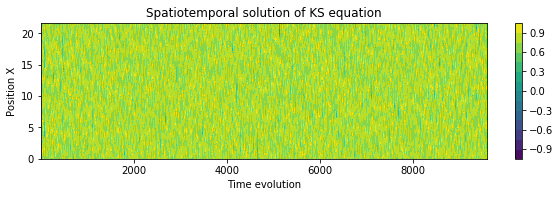

In [ ]:
#KSflow
drawKS(state_history_norm, position_x, time_counter ,startT=1,endT=800010, width = 10, divwidth = 4)

In case it is necessary to decrease the data size:

In [ ]:
state_history_norm=state_history_norm[5000:10000,:]
state_history_norm.shape

(5000, 64)

## Comparing the evolution of many models in different start_positions

If you want to look at several different positions and then average them, run the code below.

Setting the parameters:

In [15]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [16]:
state_history_norm.shape

(800100, 64)

In [ ]:
cd ..

In [26]:
cd ..\Users\Callado

[WinError 3] The system cannot find the path specified: '..\\Users\\Callado\\GoogleDrive'
C:\Users\Callado


In [ ]:
#changing steps_to_predict

Number_of_Models = 10
sp = [2,4,6,8,10,12,14,16,18,20] #steps_to_predict of the models
st = [25,25,25,25,25,25,25,25,25,25] #size_conv_time of the models

total_prediction = 5040

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=400 #it must be a number > size_conv_time of all models
finalpoint_1=394400
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2=100
startpoint_2=400050 #it must be a number > size_conv_time of all models
finalpoint_2=793000
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


delta_all_models_1 = np.zeros((Number_of_Models, total_prediction,start_positions_1.shape[0]))
delta_all_models_2 = np.zeros((Number_of_Models, total_prediction,start_positions_2.shape[0]))

In [ ]:
#CONV 1D

for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model="modelcv_model2_2_500epochs_stepspred"
    nmodel=str(i)
    name = type_of_model + nmodel
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        pp1,yy1,dif1 = prediction(model,pos_1,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,pos_2,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        delta_all_models_1[i,:,ii] = dif1
        delta_all_models_2[i,:,ii] = dif2
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

In [ ]:
#FF
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model="modelff"
    nmodel=str(i+1)
    name = type_of_model + nmodel
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        pp1,yy1,dif1 = predictionFF(model,pos_1,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = predictionFF(model,pos_2,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        delta_all_models_1[i,:,ii] = dif1
        delta_all_models_2[i,:,ii] = dif2
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Text(0.5, 0, 'Lyapunov Times')

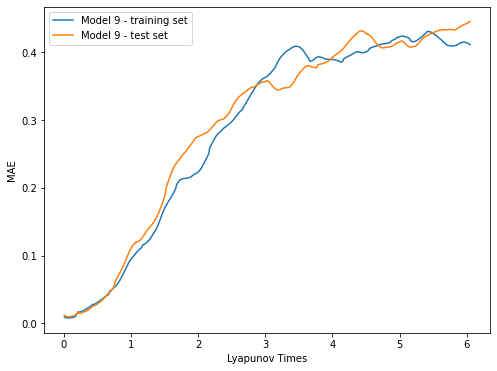

In [ ]:
plt.figure(figsize=(8,6))
labels = []
for iiii in range(Number_of_Models):
    plt.plot(np.linspace(1,int(total_prediction/10),int(total_prediction/10))*0.25/20.83, d1[iiii,:504])
    labels.append("Model "+str(iiii+1)+" - training set")
plt.legend(labels)
plt.ylabel('MAE')
plt.xlabel('Lyapunov Times')

for iiii in range(Number_of_Models):
    plt.plot(np.linspace(1,int(total_prediction/10),int(total_prediction/10))*0.25/20.83, d2[iiii,:504])
    labels.append("Model "+str(iiii+1)+" - test set")
plt.legend(labels)
plt.ylabel('MAE')
plt.xlabel('Lyapunov Times')

## Comparing the model with different training epochs

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/differents_epochs/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\differents_epochs


In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [ ]:
size_conv_time=150
steps_to_predict=50

N_step_simu=100

Iteractions_Epochs = 34
delta_epochs = 5


#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


comparator_1 = np.zeros((Iteractions_Epochs,numberofpos_1))
comparator_2 = np.zeros((Iteractions_Epochs,numberofpos_2))

for i in range(Iteractions_Epochs):
    # Load the file
    checkpoint = th.load(str(i))
    # restore the model and optimizer states:
    #model=checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    batch_size = checkpoint['batch_size']
    loss_fn=checkpoint['loss']
    train_losses=checkpoint['training loss']
    valid_losses=checkpoint['valid loss']
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,ii] = np.mean(dif1)
        comparator_2[i,ii] = np.mean(dif2)
#taking the mean of all positions
c1=np.mean(comparator_1,axis=1)
c2=np.mean(comparator_2,axis=1)

## Testing if the model can predict different datasets

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [ ]:
size_conv_time=150
steps_to_predict=50

# Load the the model
checkpoint = th.load("modelcv3_model2_u3")

# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

In [ ]:
Number_of_Datasets = 4

N_step_simu = 60

total_prediction = N_step_simu*steps_to_predict

#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

comparator_1 = np.zeros((Number_of_Datasets, total_prediction, numberofpos_1))
comparator_2 = np.zeros((Number_of_Datasets, total_prediction, numberofpos_2))

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/dataset3/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset3


In [ ]:
#load dataset
datasetnames=['u1','u2','u3','u4']

for i in range(Number_of_Datasets):
    print(datasetnames[i])
    state_history = np.loadtxt('state_history_3_'+ datasetnames[i] +'.dat')
    time_counter = np.loadtxt('time_counter_3_'+ datasetnames[i] +'.dat')
    position_x = np.loadtxt('position_3_'+datasetnames[i]+'.dat')
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
    state_history_norm = min_max_scaler.fit_transform(state_history)
    state_history_norm_th = th.from_numpy(state_history_norm).cuda()
    #making the prediction
    for ii in range(numberofpos_1):
        #making the prediction
        pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        comparator_1[i,:,ii] = dif1
        comparator_2[i,:,ii] = dif2
#taking the mean of all positions
c1=np.mean(comparator_1,axis=2)
c2=np.mean(comparator_2,axis=2)

u1
u2
u3
u4


In [ ]:
#DATASET1

colors = ['red','blue','black','yellow']
legends = ['Dataset1_u1 (not used to train)','Dataset1_u2 (not used to train)','Dataset1_u3 (training set)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('With the training part of Dataset1_u3')
plt.show()

legends = ['Dataset1_u1 (not used to train)','Dataset1_u2 (not used to train)','Dataset1_u3 (test set)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('With the test part of Dataset1_u3')
plt.show()

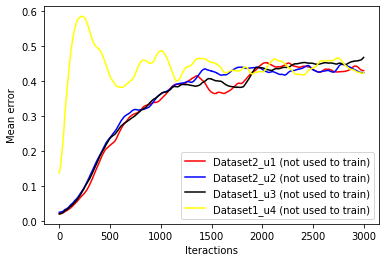

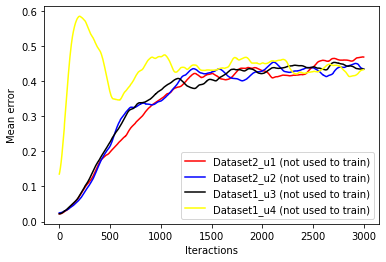

In [ ]:
#DATASET2

colors = ['red','blue','black','yellow']
legends = ['Dataset2_u1 (not used to train)','Dataset2_u2 (not used to train)','Dataset1_u3 (not used to train)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.show()

legends = ['Dataset2_u1 (not used to train)','Dataset2_u2 (not used to train)','Dataset1_u3 (not used to train)','Dataset1_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.show()

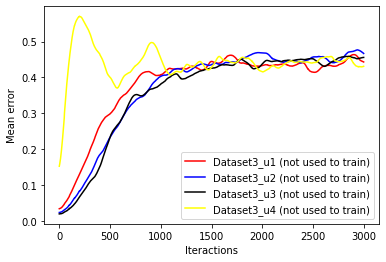

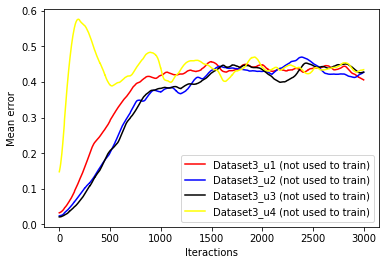

In [ ]:
#DATASET3

colors = ['red','blue','black','yellow']
legends = ['Dataset3_u1 (not used to train)','Dataset3_u2 (not used to train)','Dataset3_u3 (not used to train)','Dataset3_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.show()

legends = ['Dataset3_u1 (not used to train)','Dataset3_u2 (not used to train)','Dataset3_u3 (not used to train)','Dataset3_u4 (not used to train)']

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c2[i,:],colors[i])
plt.legend(legends)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.show()

## Comparing the prediction of the model and simulators for the data generated by  the model

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [ ]:
size_conv_time=150
steps_to_predict=50

# Load the the model
checkpoint = th.load("modelcv3_model2_u3")

# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

Number_of_Models = 1 

total_prediction = 1500

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=100000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2 = 100
startpoint_2 = 100000
finalpoint_2 = 185000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

#to save the performance of the model to prediction of training and test set
delta_all_models_1 = np.zeros((Number_of_Models, total_prediction,start_positions_1.shape[0]))
delta_all_models_2 = np.zeros((Number_of_Models, total_prediction,start_positions_2.shape[0]))

#to save directly the prediction and the true value
statespred1 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0]))
statespred2 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0])) 

In [ ]:
state_history1.shape

torch.Size([301, 64])

In [ ]:
for jj in range(Number_of_Models):
    for ii in range(start_positions_1.shape[0]):
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        number_of_steps_pred=int(size_conv_time/steps_to_predict)
        for i in range(int(N_step_simu/number_of_steps_pred)):
            if i==0:
                pp1,yy1,dif1 = prediction(model,pos_1,number_of_steps_pred,steps_to_predict,size_conv_time,state_history_norm_th)
                pp2,yy2,dif2 = prediction(model,pos_2,number_of_steps_pred,steps_to_predict,size_conv_time,state_history_norm_th)
                delta_all_models_1[jj,i*steps_to_predict:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif1
                delta_all_models_2[jj,i*steps_to_predict:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif2
                statespred1[0:size_conv_time,:,ii]=pp1
                statespred2[0:size_conv_time,:,ii]=yy1

            else:
                pos_1 = size_conv_time
                pos_2 = size_conv_time
                pp1_u = min_max_scaler.inverse_transform(pp1)
                pp2_u = min_max_scaler.inverse_transform(pp2)
                state_history1, time_counter, position_x = generatingdata(pp1_u[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)
                state_history2, time_counter, position_x = generatingdata(pp2_u[size_conv_time-1], length,sample_points,dt,size_conv_time*2*dt)            

                #normalizing the data generated:
                state_history1 = min_max_scaler.transform(state_history1)
                state_history2 = min_max_scaler.transform(state_history2)
                
                state_history1 = th.from_numpy(state_history1)
                state_history2 = th.from_numpy(state_history2)
                pp1,yy1,dif1 = prediction(model,pos_1,number_of_steps_pred,steps_to_predict,size_conv_time,state_history1)
                pp2,yy2,dif2 = prediction(model,pos_2,number_of_steps_pred,steps_to_predict,size_conv_time,state_history2)

                delta_all_models_1[jj,i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif1
                delta_all_models_2[jj,i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif2
                statespred1[i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,:,ii]=pp1
                statespred2[i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,:,ii]=yy1
        
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is:

The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The st

100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15.0 seconds with 300 iteractions
100th iteraction: ok
The state_history shape is: (301, 64)
The final time: 15.0
Running for :  15

In [ ]:
state_history1[1:].shape

(150, 64)

Text(0.5, 0, 'Initial position')

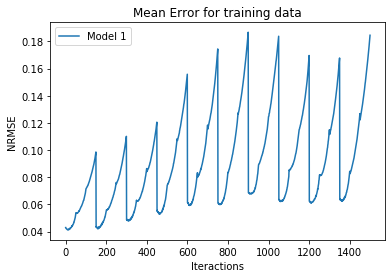

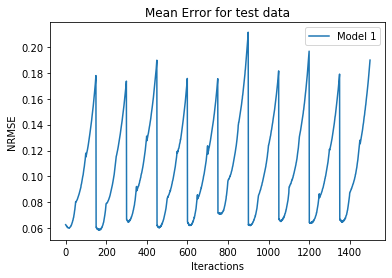

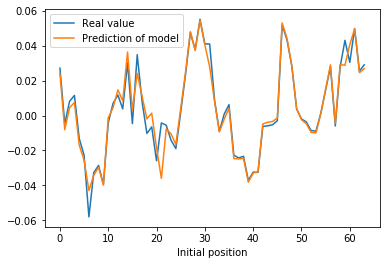

In [ ]:
plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d1[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('Mean Error for training data')

plt.figure()
labels = []
for iiii in range(Number_of_Models):
    plt.plot(d2[iiii,:])
    labels.append("Model "+str(iiii+1))
plt.legend(labels)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('Mean Error for test data')

n1 = np.mean(statespred1,axis=0)
n1 = np.mean(n1,axis=1)
n11 = np.mean(statespred2,axis=0)
n11 = np.mean(n11,axis=1)

plt.figure()

plt.plot(n1)
plt.plot(n11)
plt.legend(['Real value','Prediction of model'])
plt.xlabel('Initial position')

The prediction:


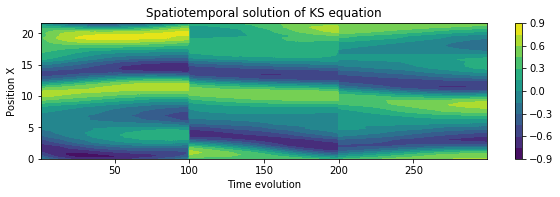

The true value:


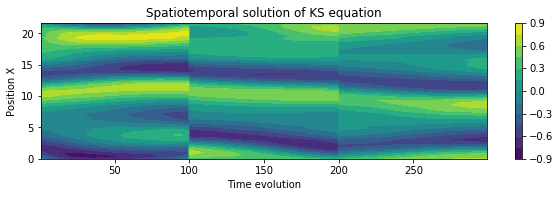

In [ ]:
time_counter=np.linspace(0,1000,1500)
#KSflow
print('The prediction:')
drawKS(statespred1[:,:,0], position_x, time_counter ,startT=1,endT=450, width = 10, divwidth = 4)
print('The true value:')
drawKS(statespred2[:,:,0], position_x, time_counter ,startT=1,endT=450, width = 10, divwidth = 4)

Another way (without skipping 150 points each time)

The prediction


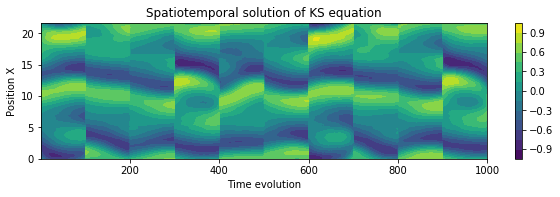

The true value


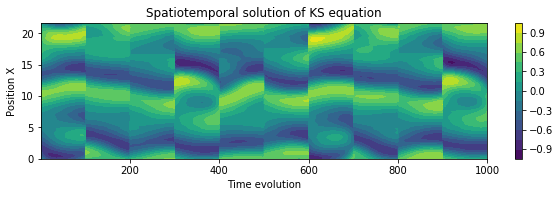

###################################
The prediction


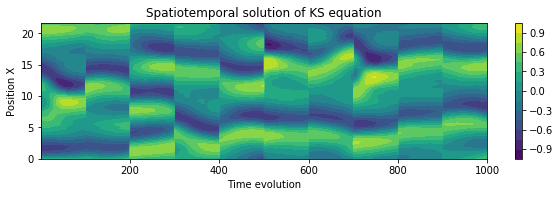

The true value


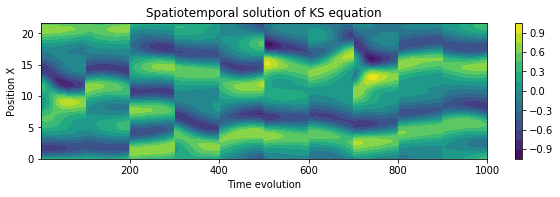

###################################
The prediction


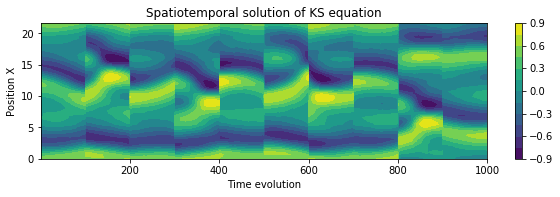

The true value


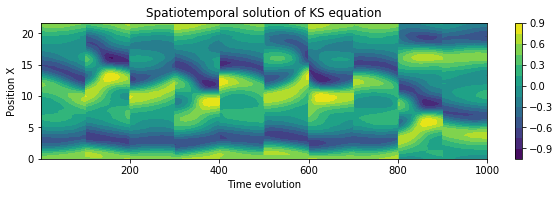

###################################
The prediction


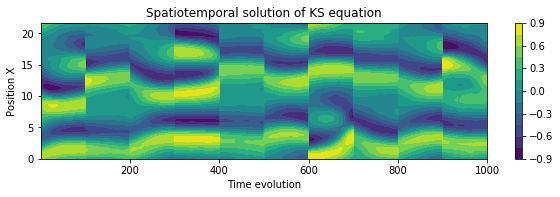

The true value


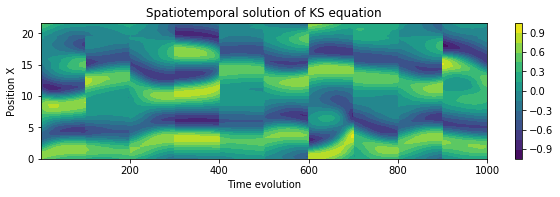

###################################
The prediction


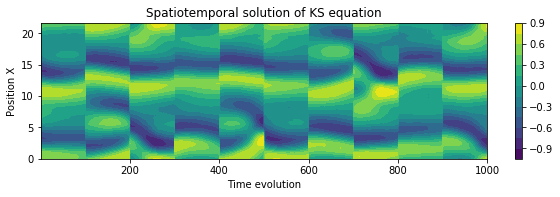

The true value


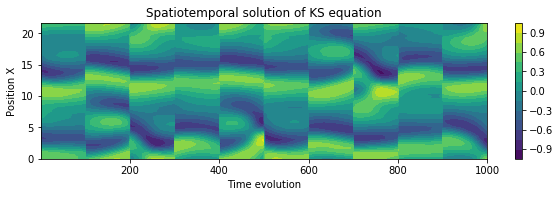

###################################
The prediction


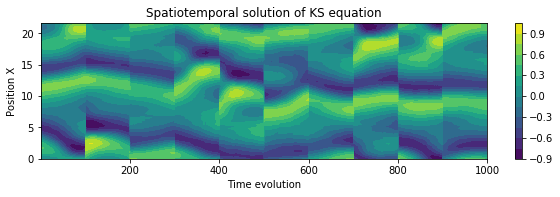

The true value


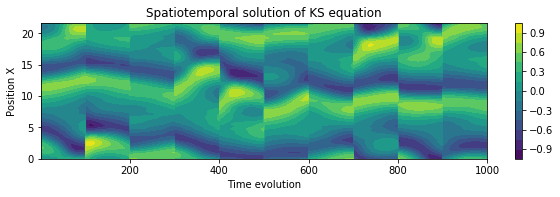

###################################
The prediction


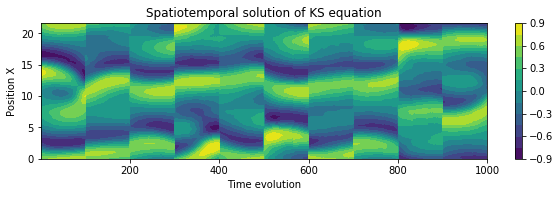

The true value


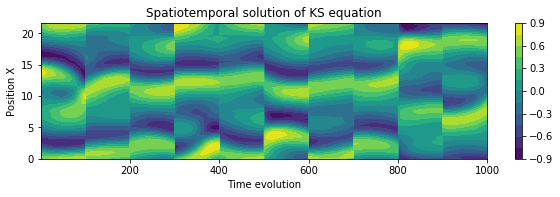

###################################
The prediction


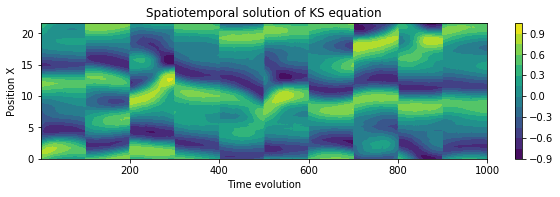

The true value


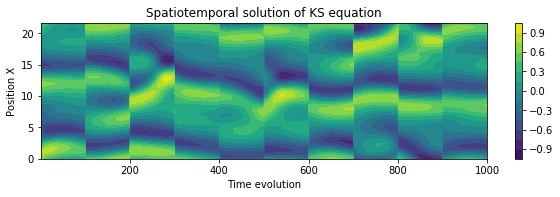

###################################
The prediction


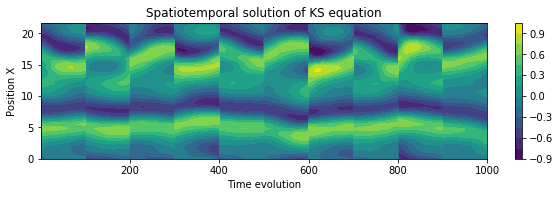

The true value


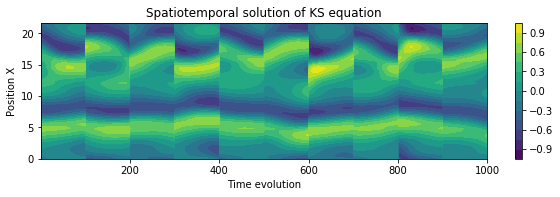

###################################
The prediction


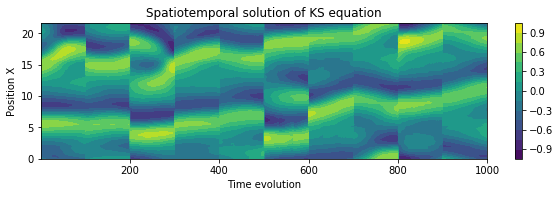

The true value


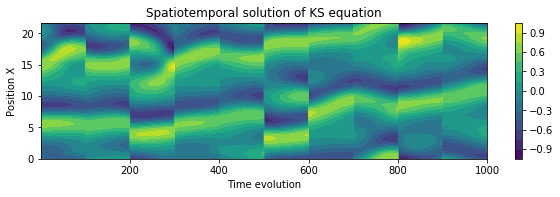

###################################
The prediction


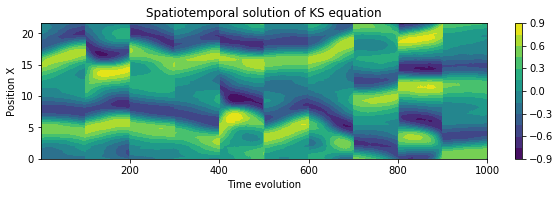

The true value


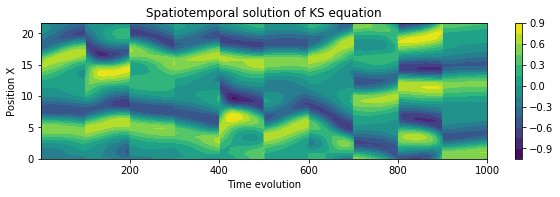

###################################
The prediction


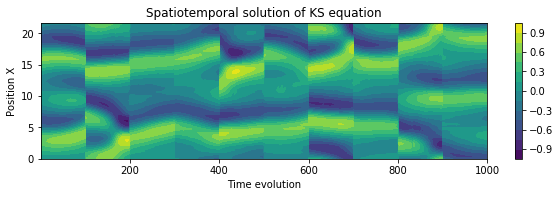

The true value


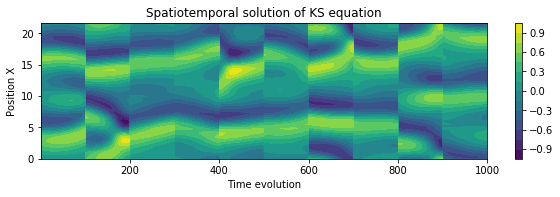

###################################
The prediction


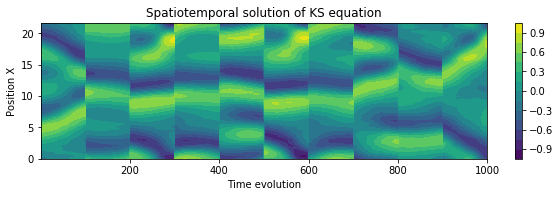

The true value


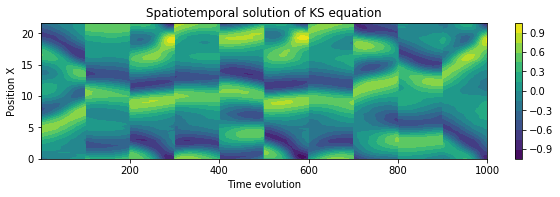

###################################
The prediction


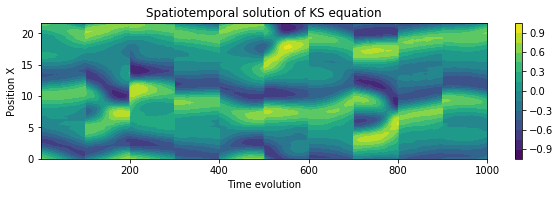

The true value


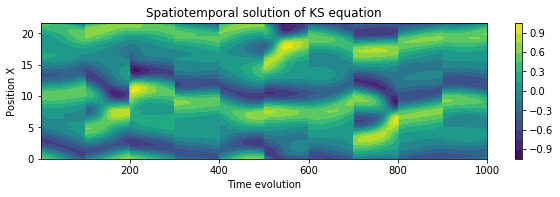

###################################
The prediction


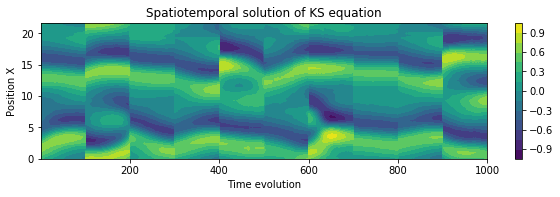

The true value


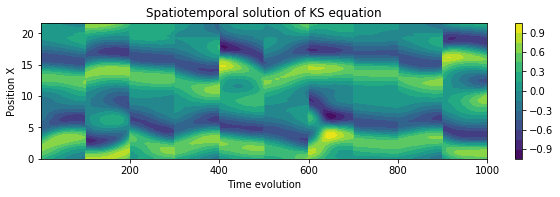

###################################
The prediction


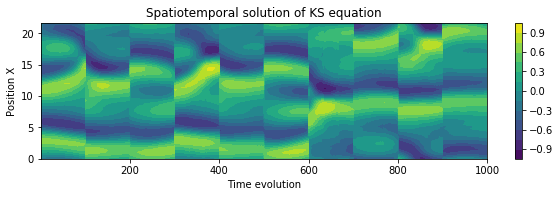

The true value


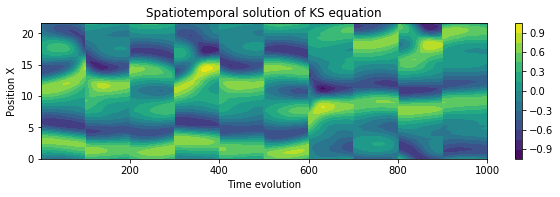

###################################
The prediction


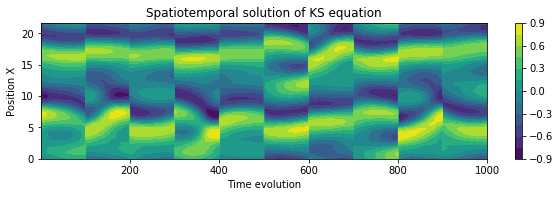

The true value


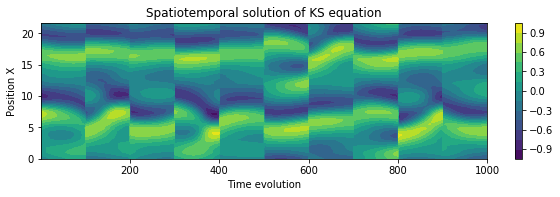

###################################
The prediction


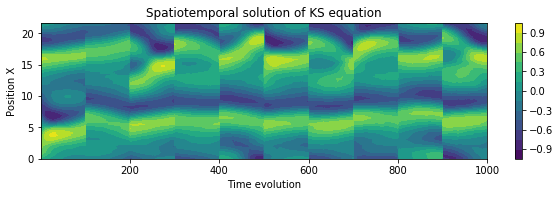

The true value


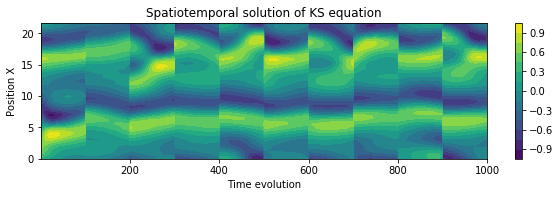

###################################
The prediction


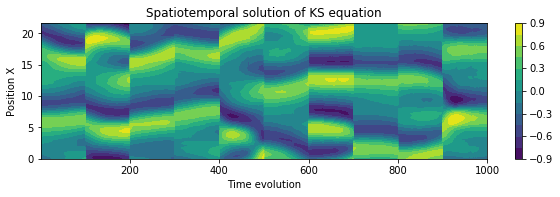

The true value


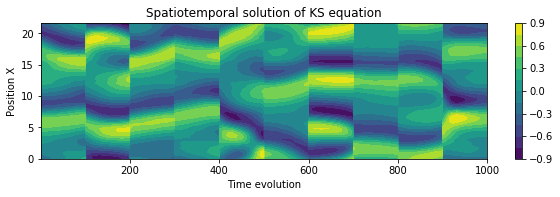

###################################
The prediction


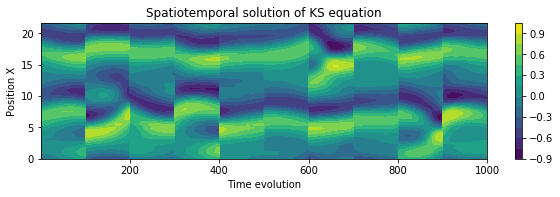

The true value


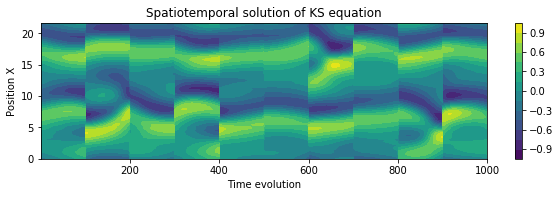

###################################
The prediction


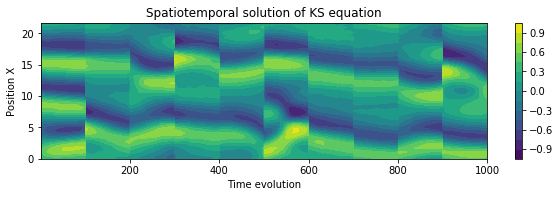

The true value


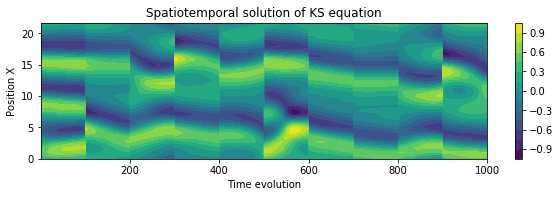

###################################
The prediction


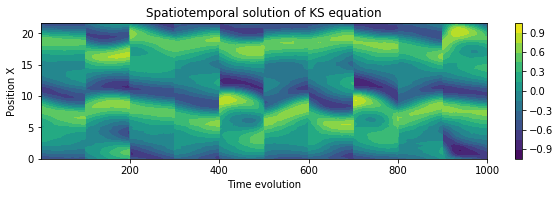

The true value


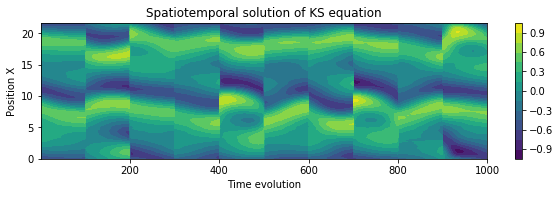

###################################
The prediction


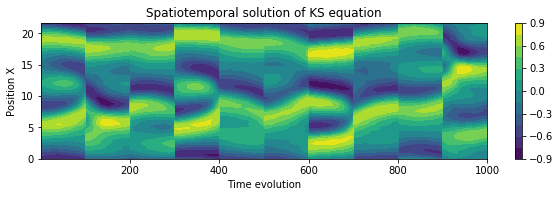

The true value


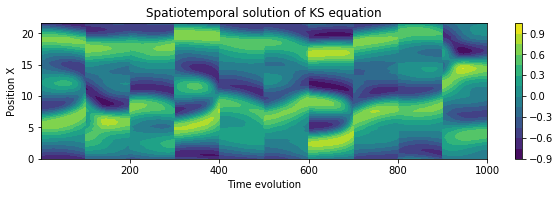

###################################
The prediction


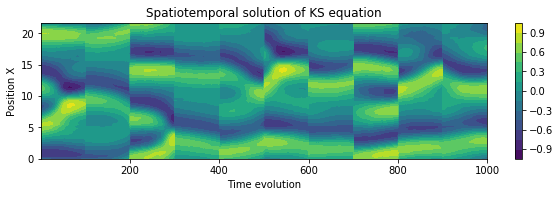

The true value


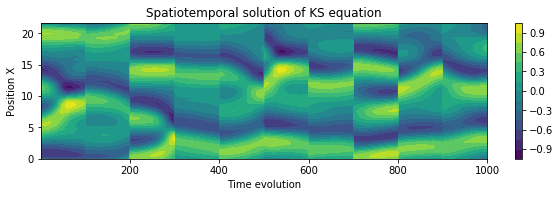

###################################
The prediction


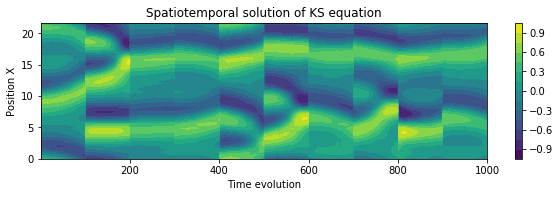

The true value


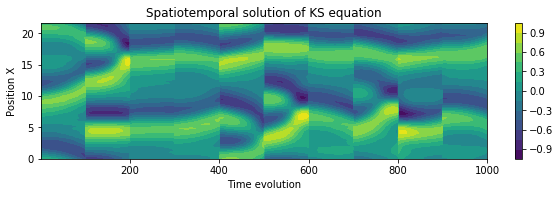

###################################
The prediction


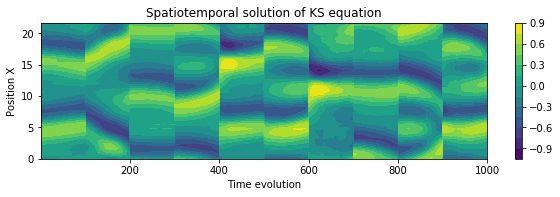

The true value


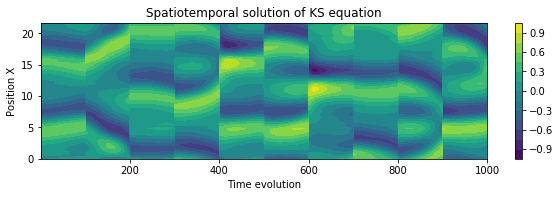

###################################
The prediction


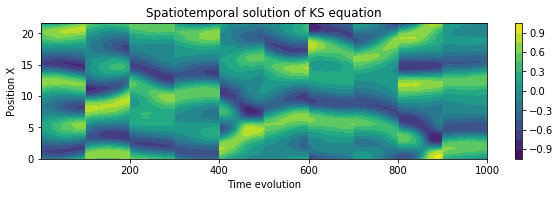

The true value


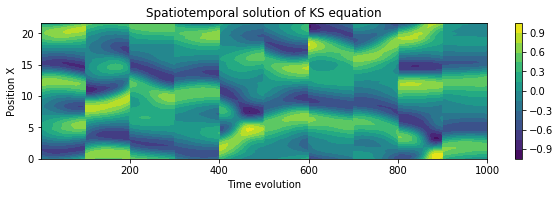

###################################
The prediction


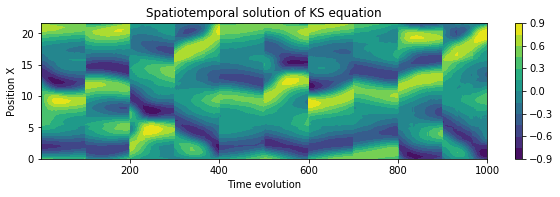

The true value


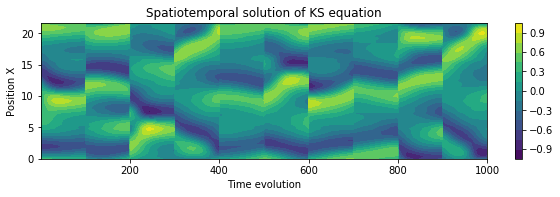

###################################
The prediction


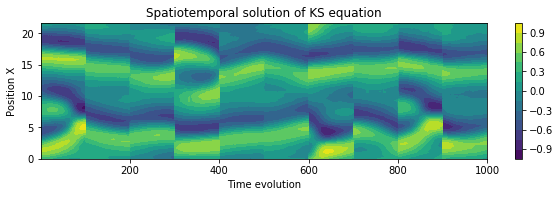

The true value


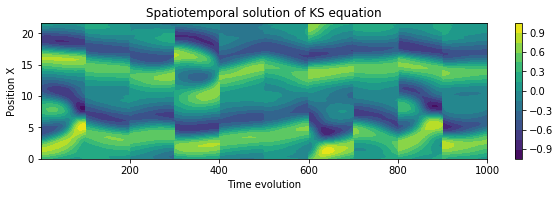

###################################
The prediction


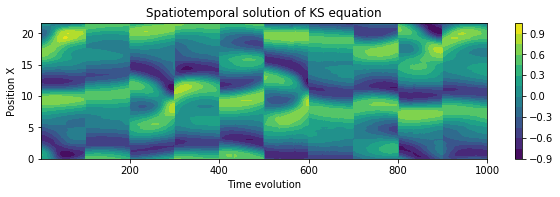

The true value


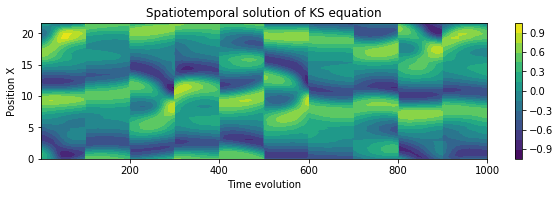

###################################
The prediction


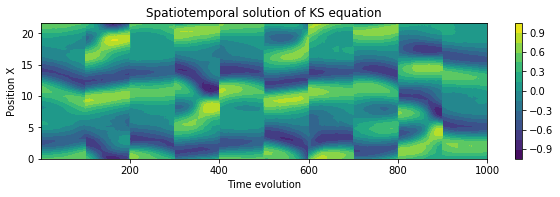

The true value


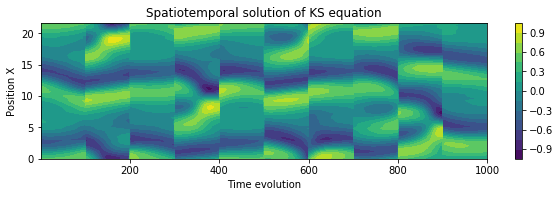

###################################
The prediction


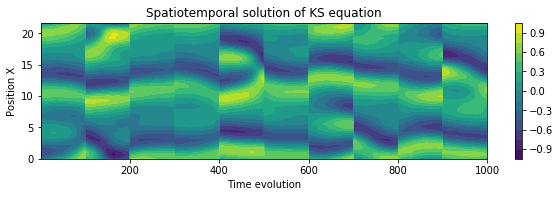

The true value


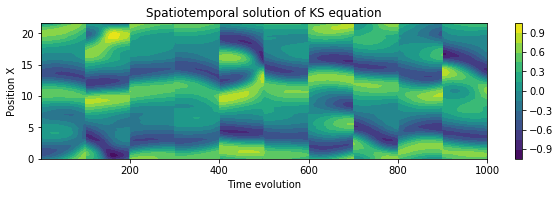

###################################
The prediction


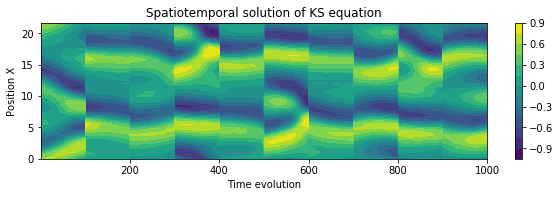

The true value


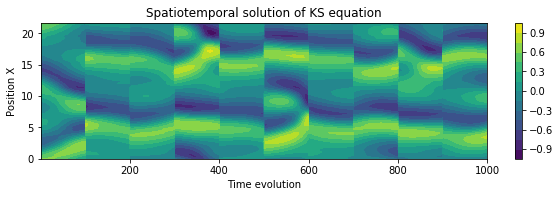

###################################
The prediction


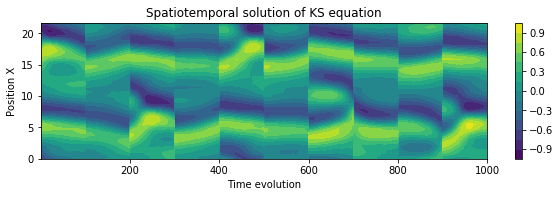

The true value


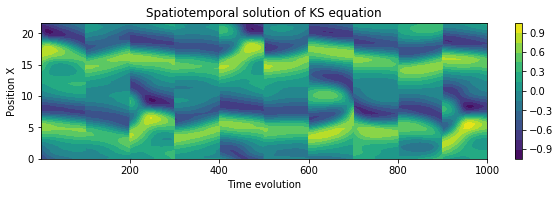

###################################
The prediction


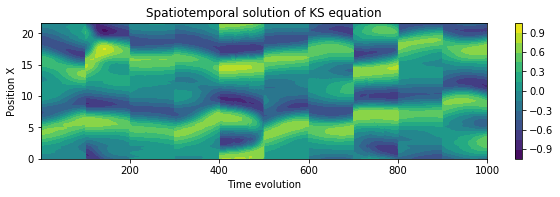

The true value


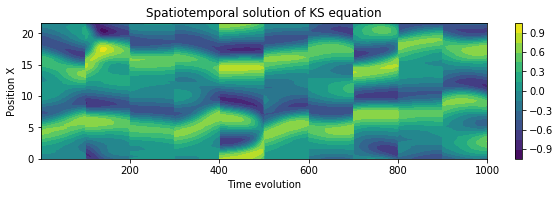

###################################
The prediction


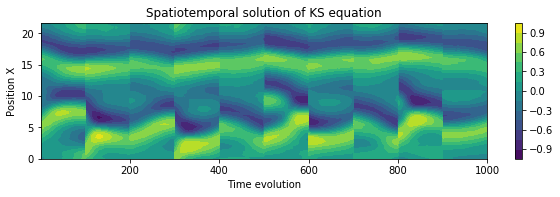

The true value


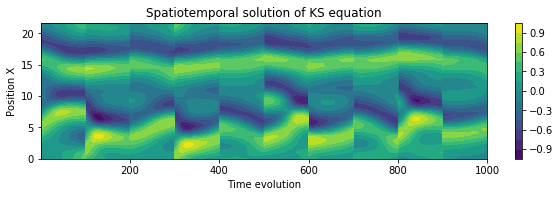

###################################
The prediction


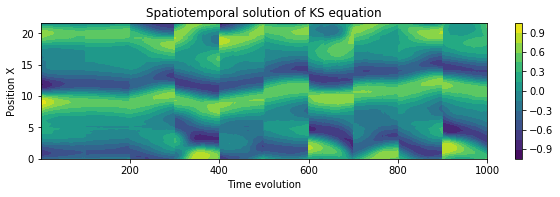

The true value


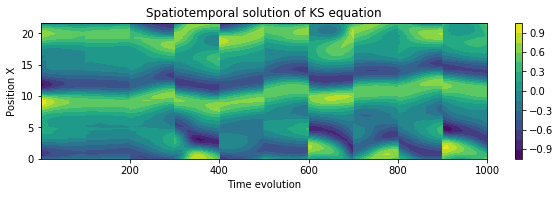

###################################
The prediction


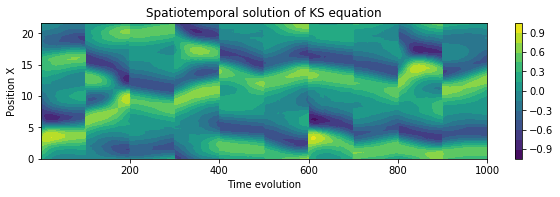

The true value


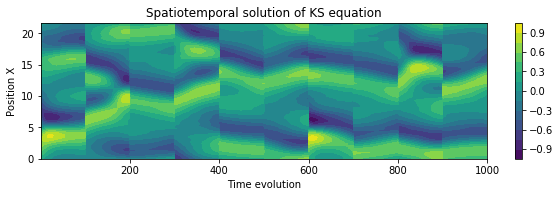

###################################
The prediction


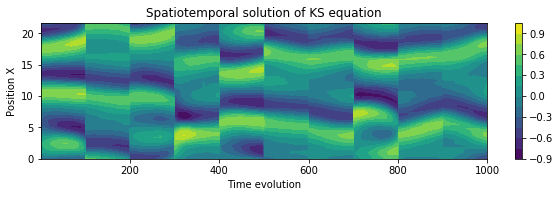

The true value


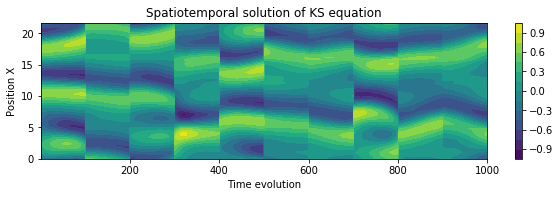

###################################
The prediction


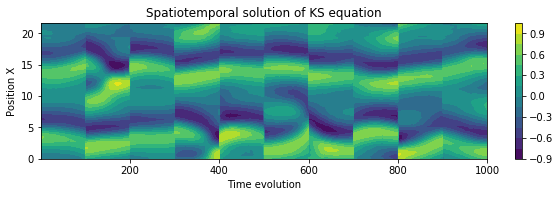

The true value


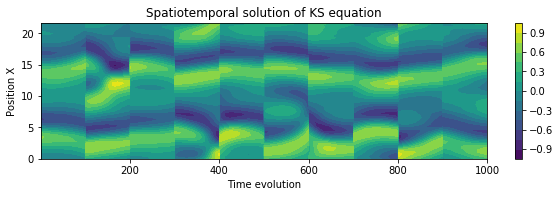

###################################
The prediction


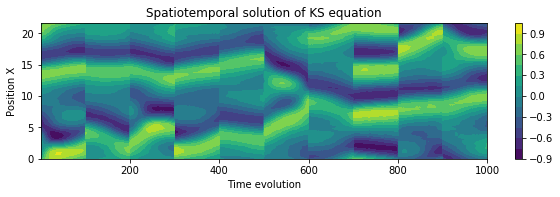

The true value


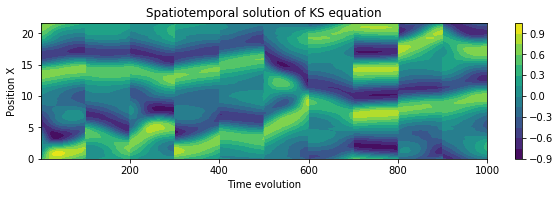

###################################
The prediction


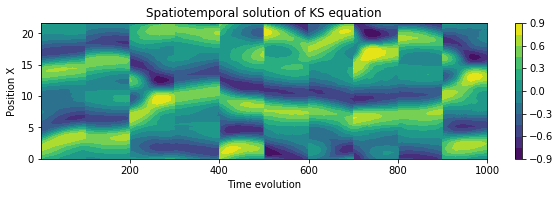

The true value


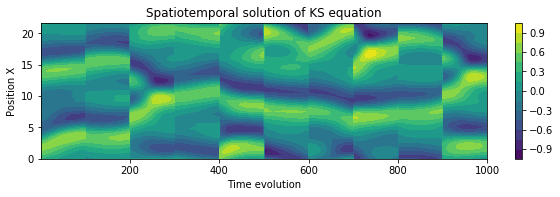

###################################
The prediction


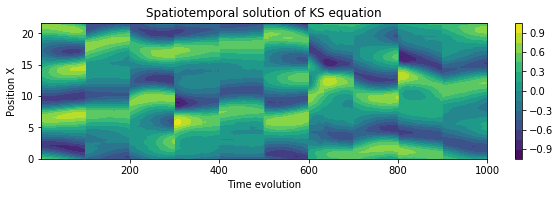

The true value


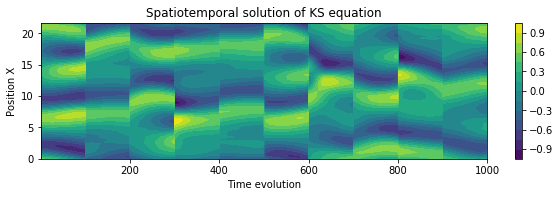

###################################
The prediction


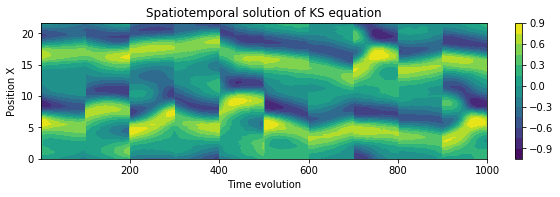

The true value


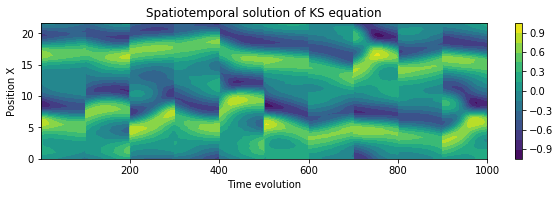

###################################
The prediction


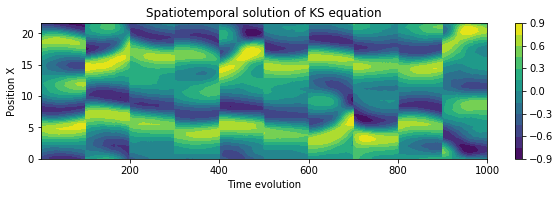

The true value


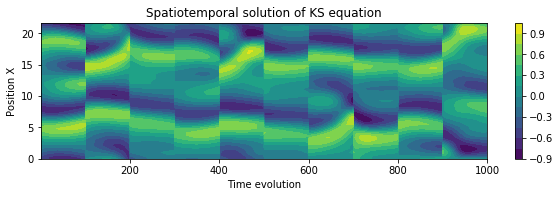

###################################
The prediction


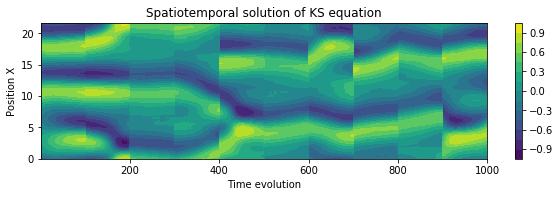

The true value


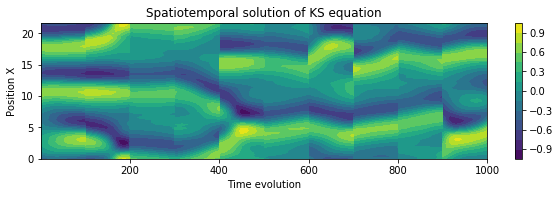

###################################
The prediction


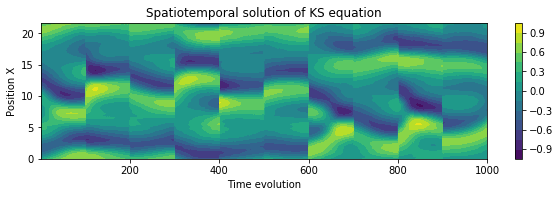

The true value


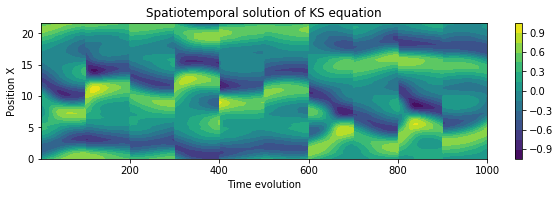

###################################
The prediction


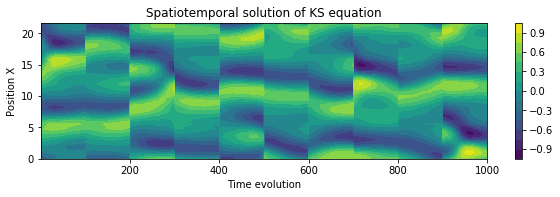

The true value


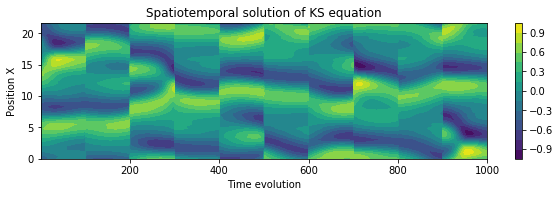

###################################
The prediction


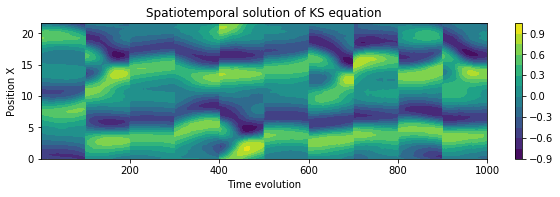

The true value


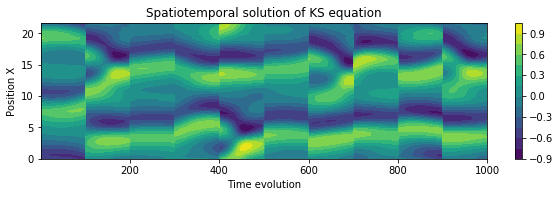

###################################
The prediction


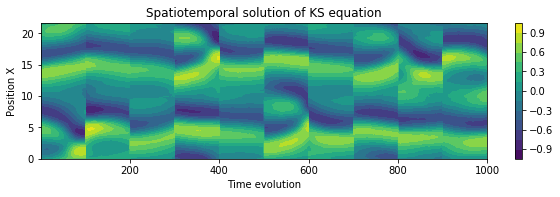

The true value


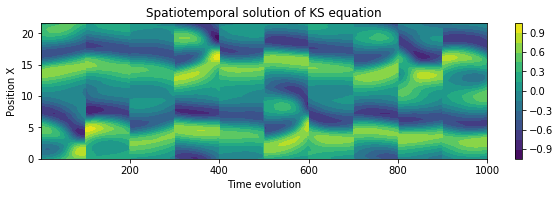

###################################
The prediction


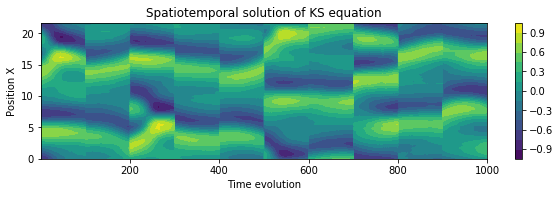

The true value


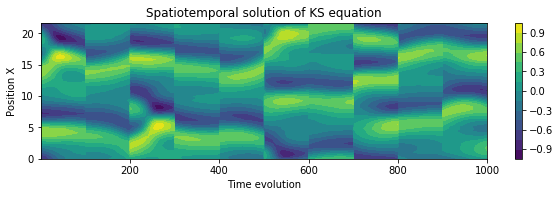

###################################
The prediction


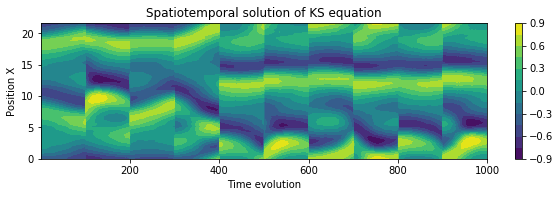

The true value


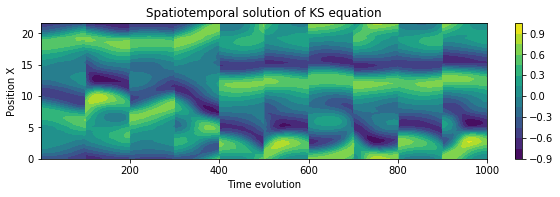

###################################
The prediction


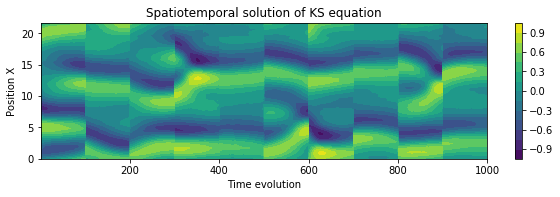

The true value


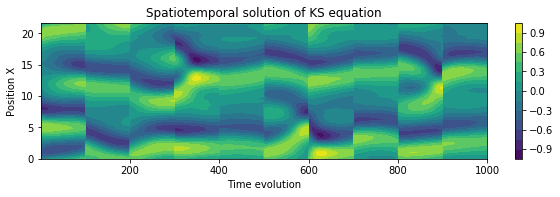

###################################
The prediction


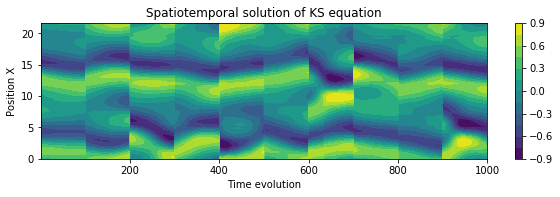

The true value


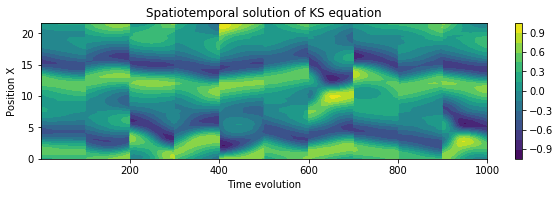

###################################
The prediction


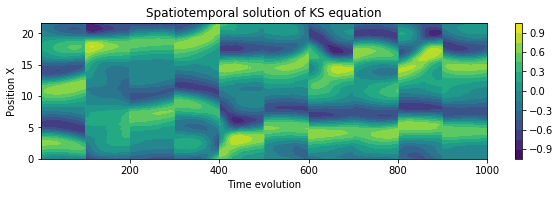

The true value


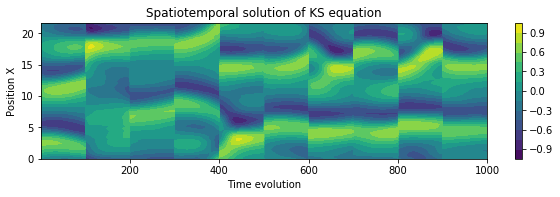

###################################
The prediction


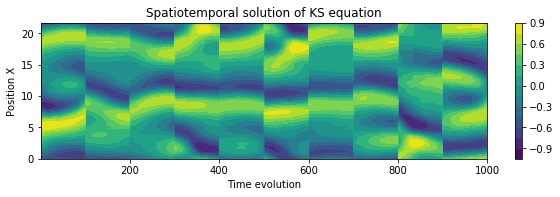

The true value


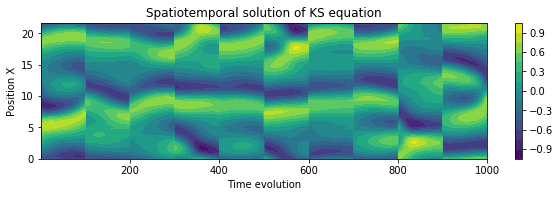

###################################
The prediction


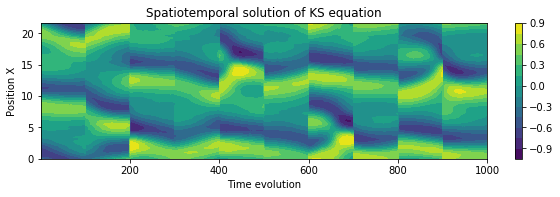

The true value


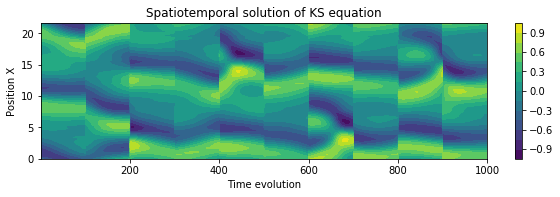

###################################
The prediction


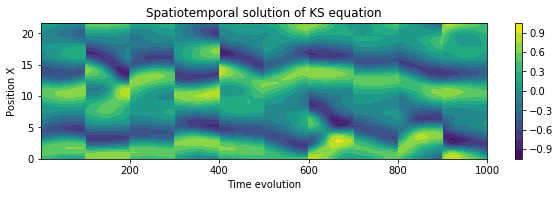

The true value


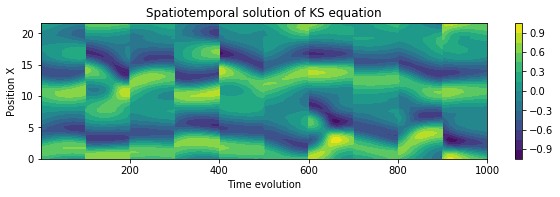

###################################
The prediction


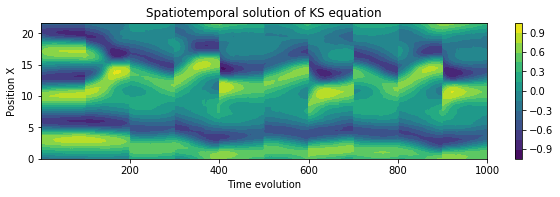

The true value


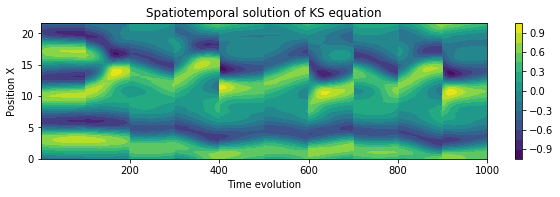

###################################
The prediction


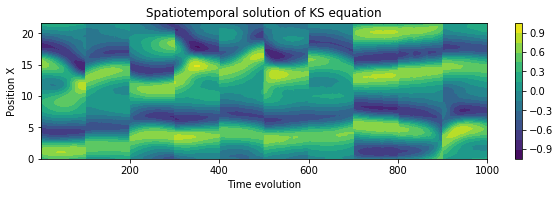

The true value


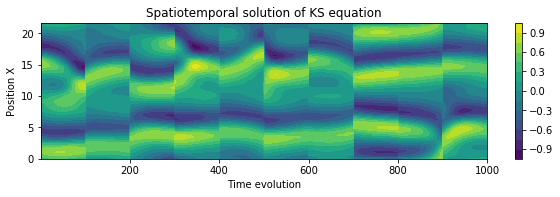

###################################
The prediction


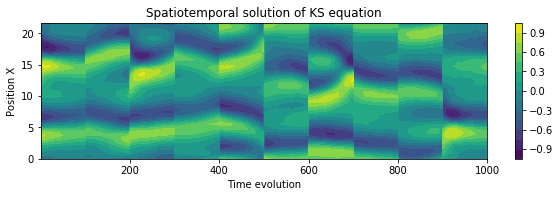

The true value


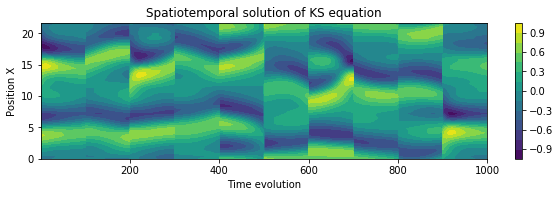

###################################
The prediction


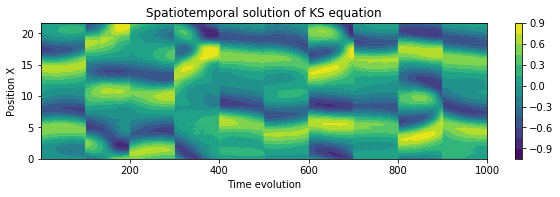

The true value


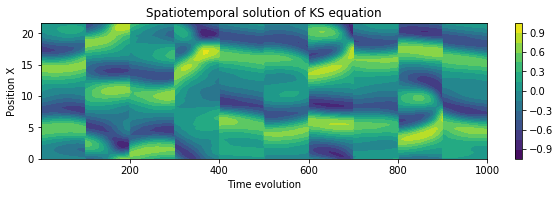

###################################
The prediction


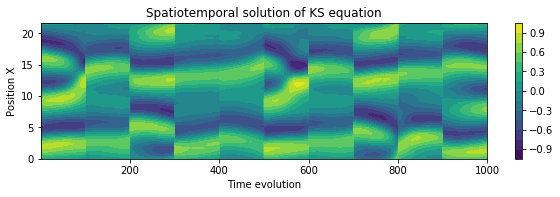

The true value


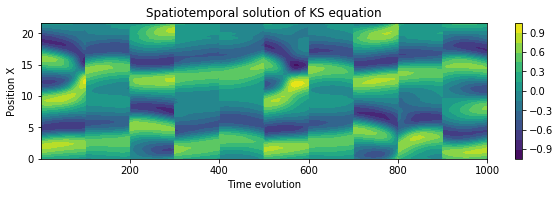

###################################
The prediction


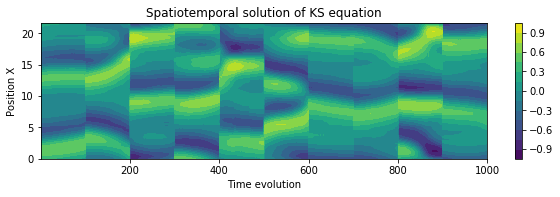

The true value


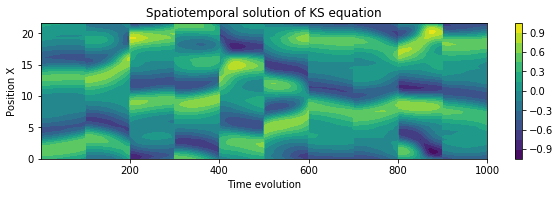

###################################
The prediction


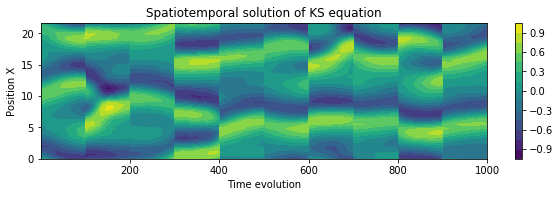

The true value


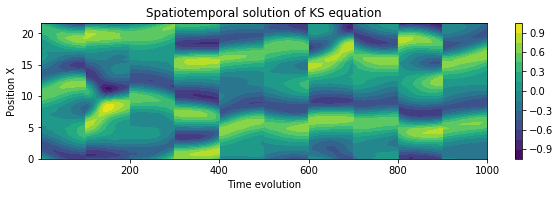

###################################
The prediction


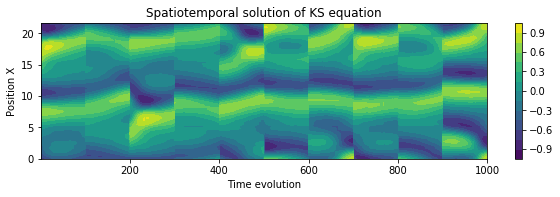

The true value


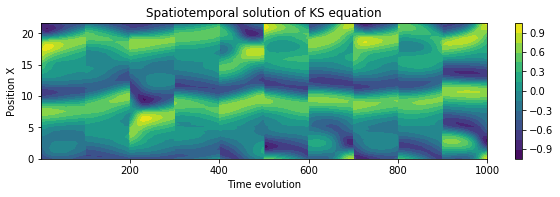

###################################
The prediction


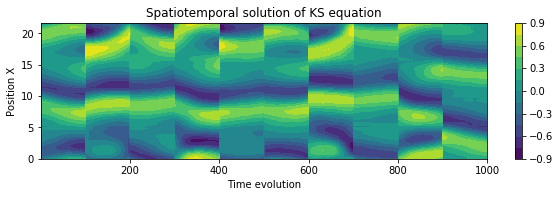

The true value


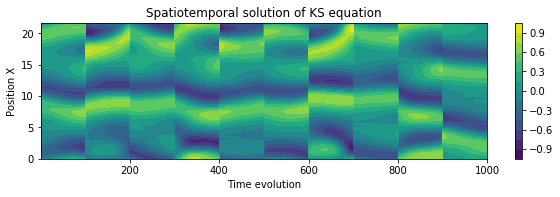

###################################
The prediction


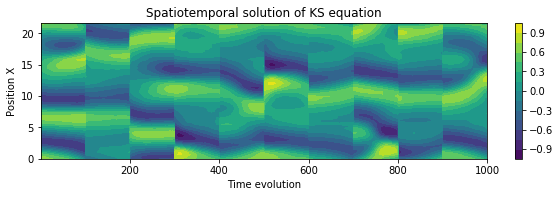

The true value


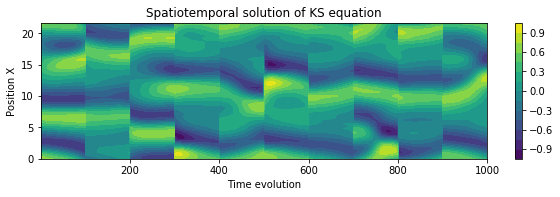

###################################
The prediction


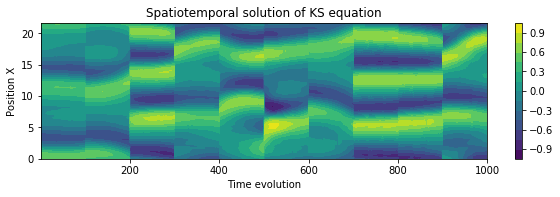

The true value


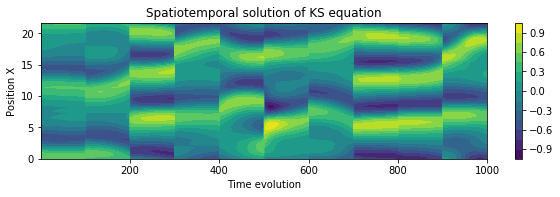

###################################
The prediction


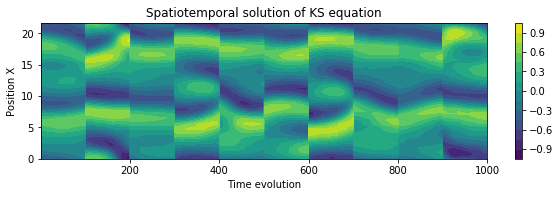

The true value


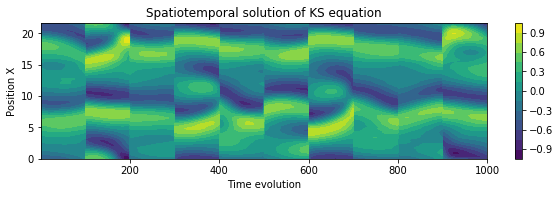

###################################
The prediction


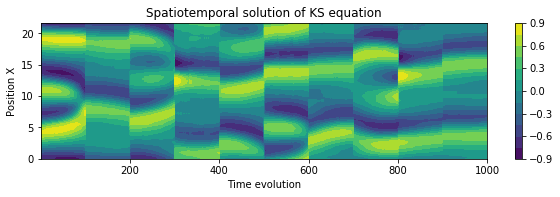

The true value


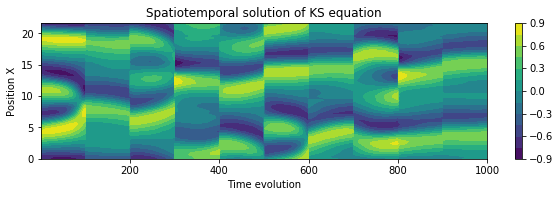

###################################
The prediction


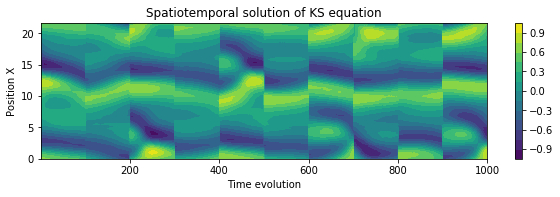

The true value


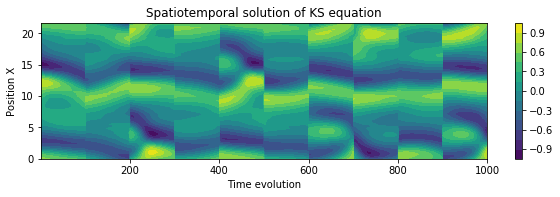

###################################
The prediction


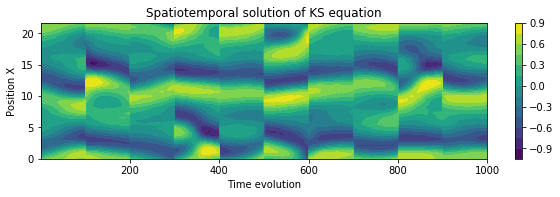

The true value


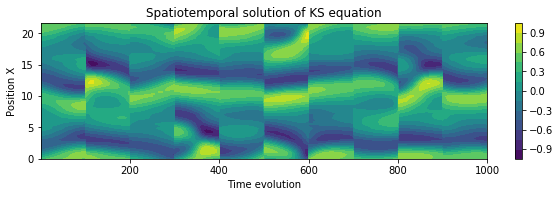

###################################
The prediction


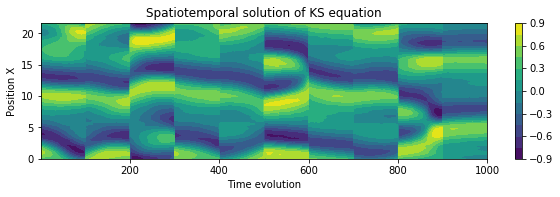

The true value


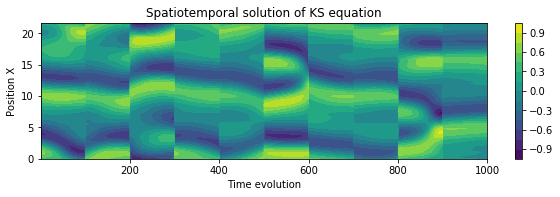

###################################
The prediction


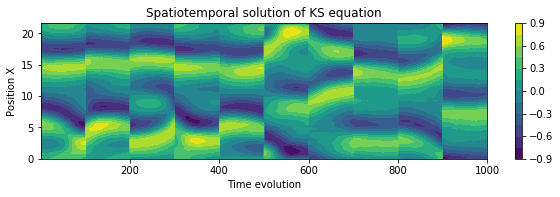

The true value


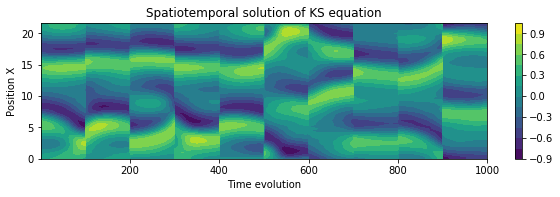

###################################
The prediction


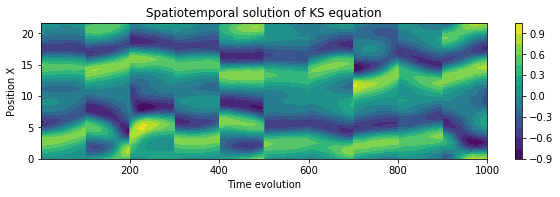

The true value


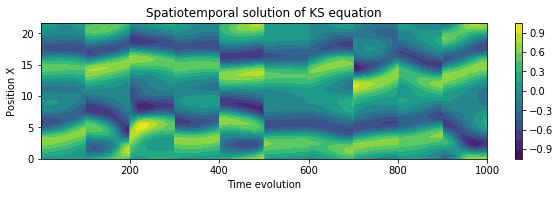

###################################
The prediction


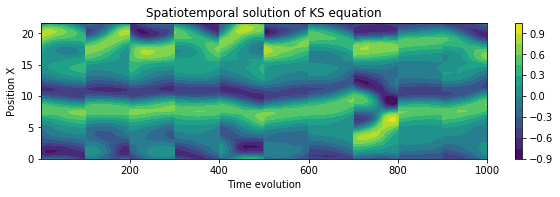

The true value


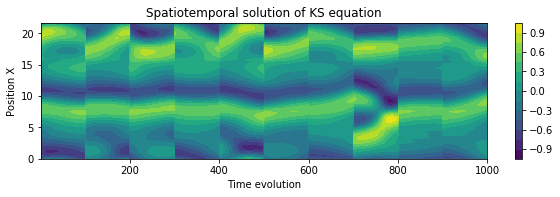

###################################
The prediction


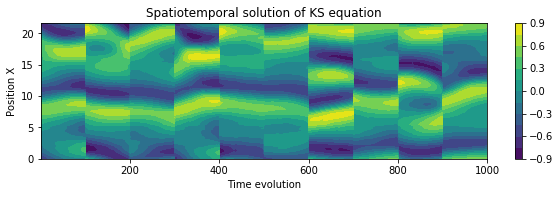

The true value


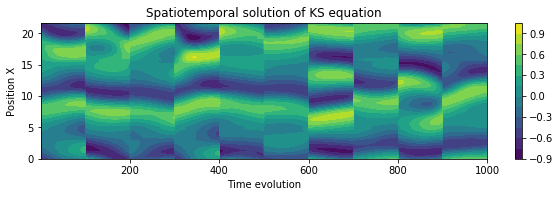

###################################
The prediction


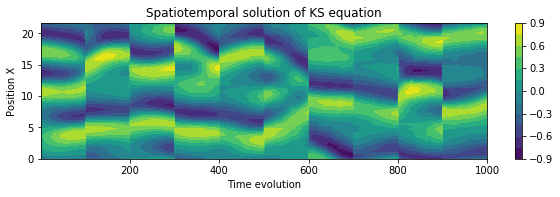

The true value


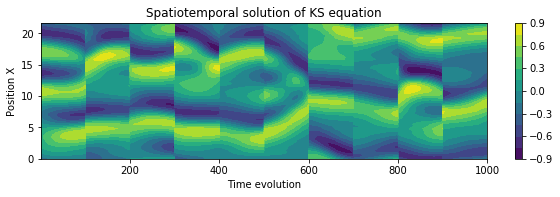

###################################
The prediction


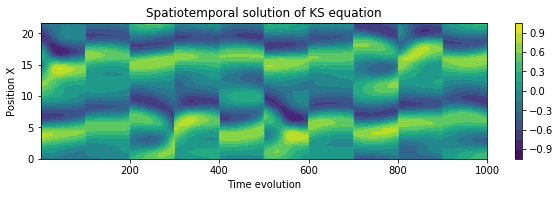

The true value


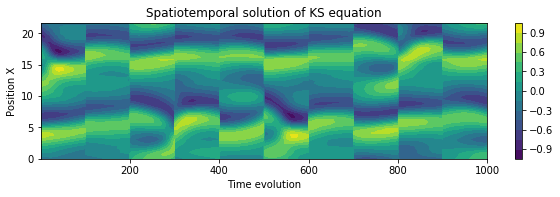

###################################
The prediction


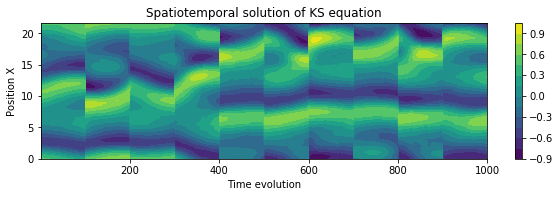

The true value


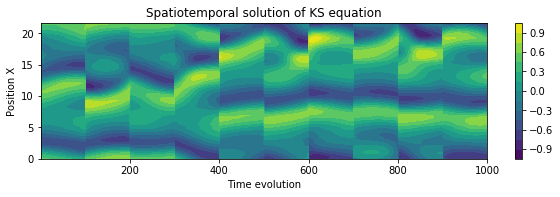

###################################
The prediction


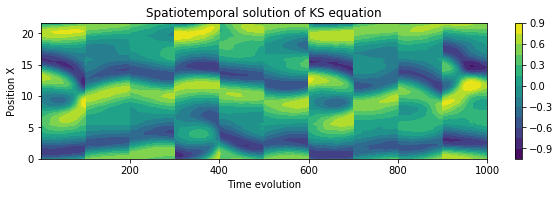

The true value


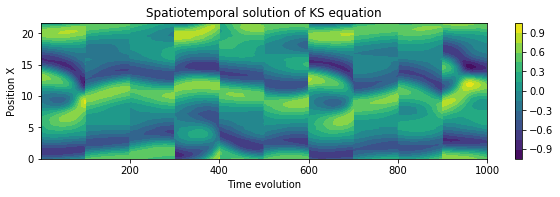

###################################
The prediction


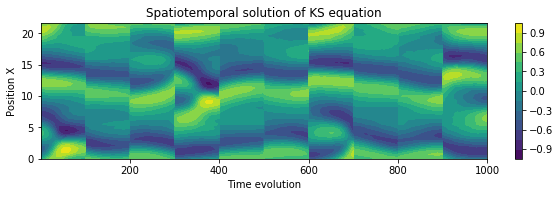

The true value


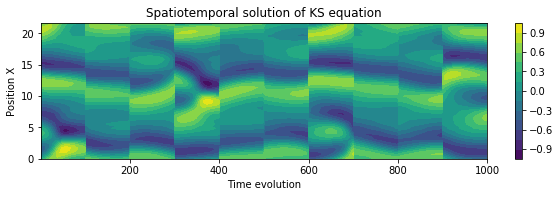

###################################
The prediction


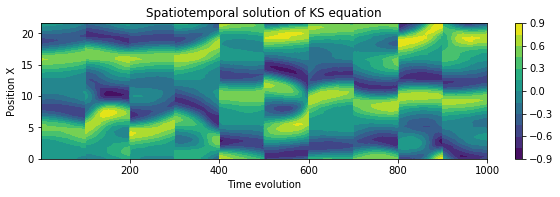

The true value


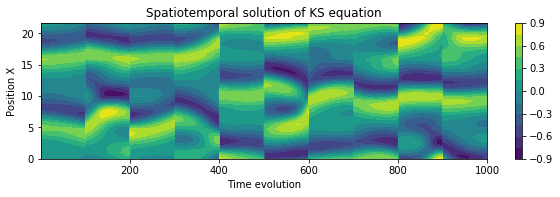

###################################
The prediction


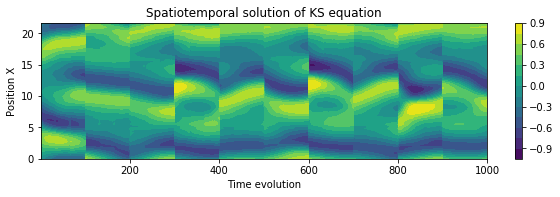

The true value


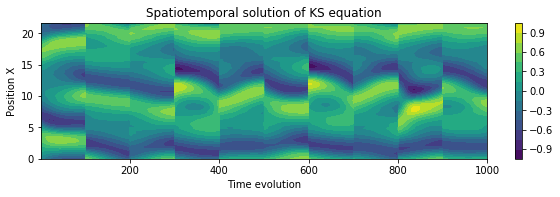

###################################
The prediction


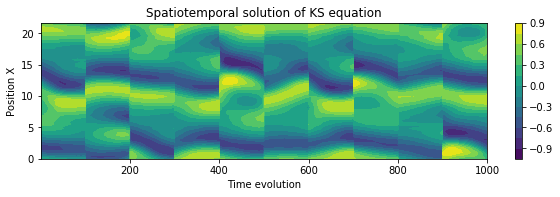

The true value


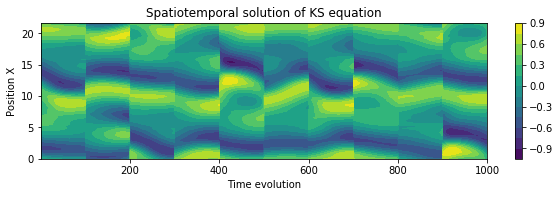

###################################
The prediction


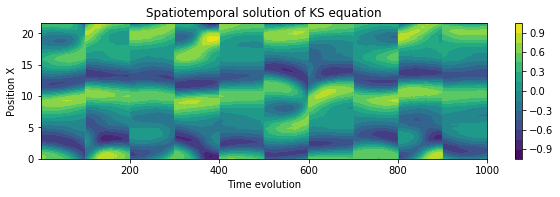

The true value


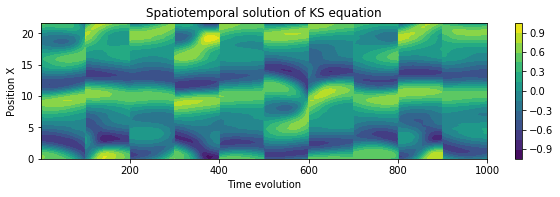

###################################
The prediction


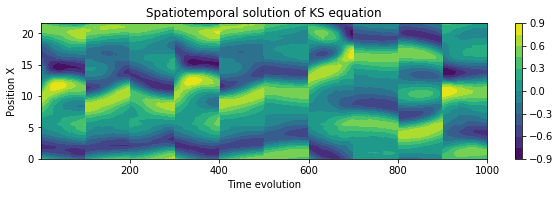

The true value


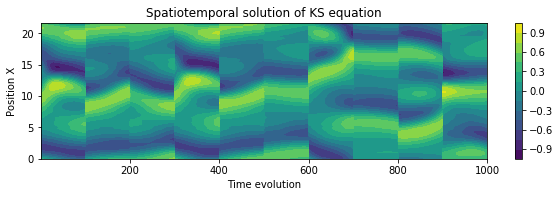

###################################
The prediction


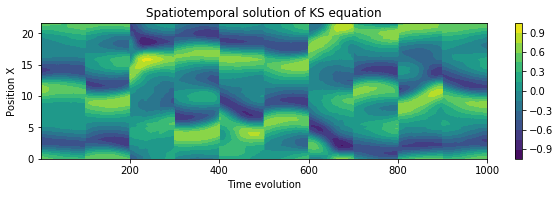

The true value


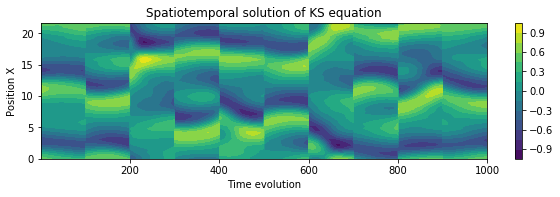

###################################
The prediction


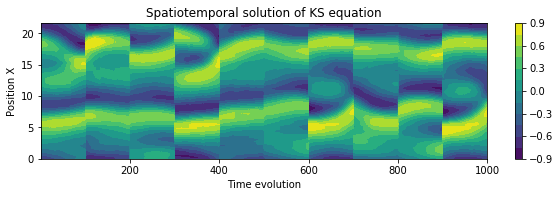

The true value


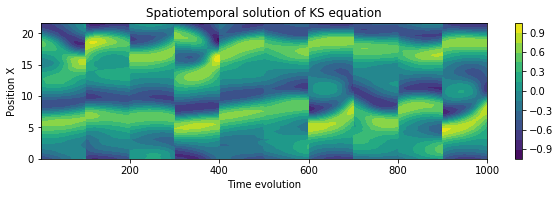

###################################
The prediction


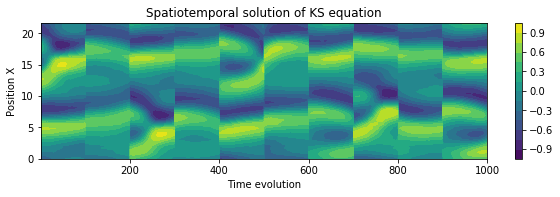

The true value


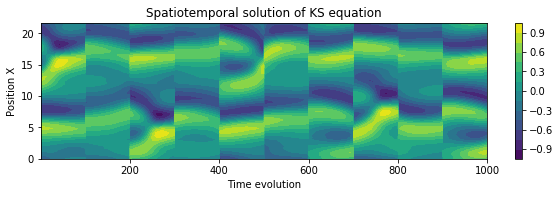

###################################
The prediction


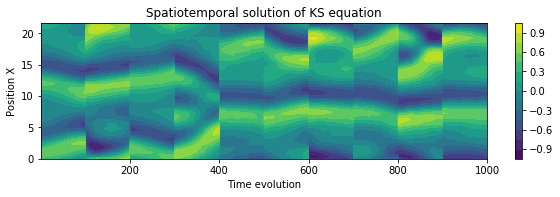

The true value


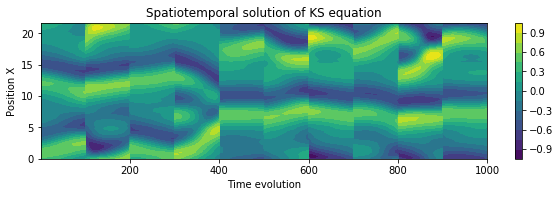

###################################
The prediction


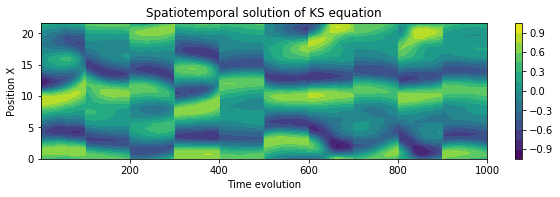

The true value


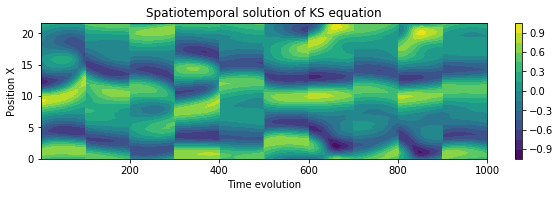

###################################
The prediction


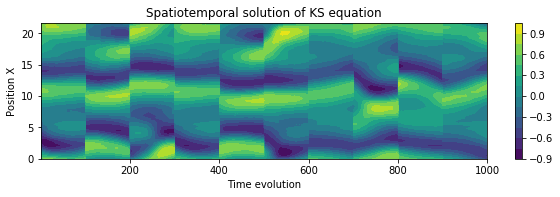

The true value


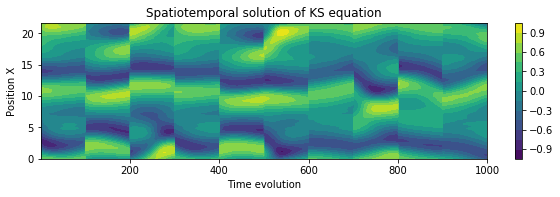

###################################
The prediction


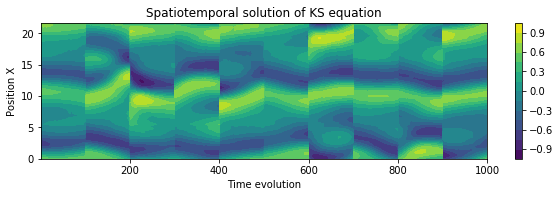

The true value


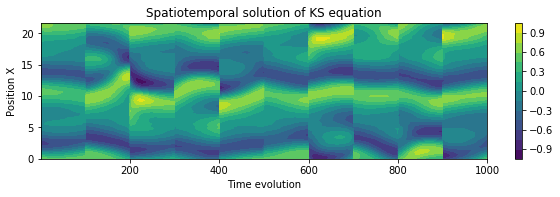

###################################
The prediction


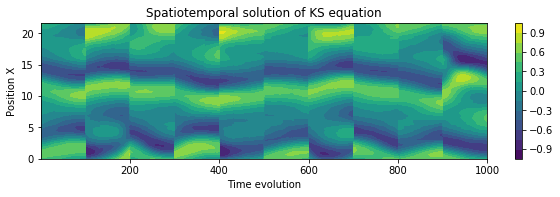

The true value


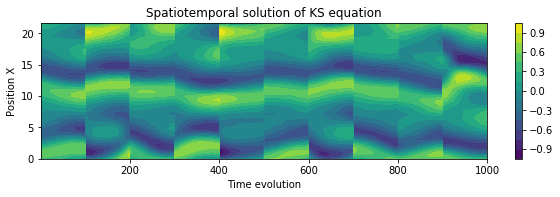

###################################
The prediction


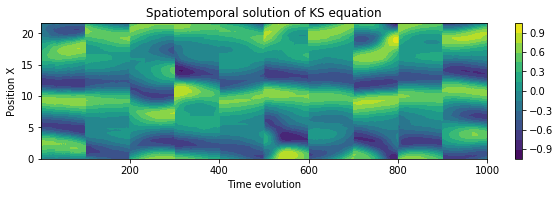

The true value


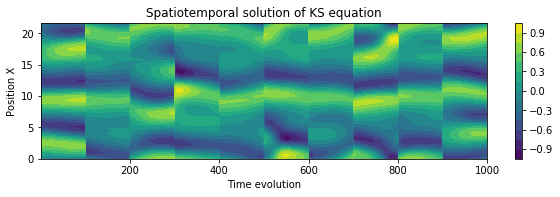

###################################
The prediction


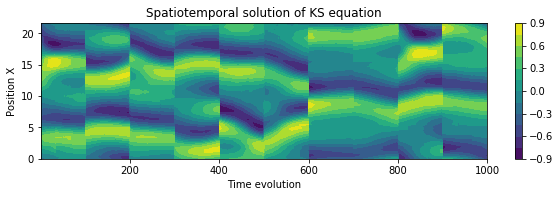

The true value


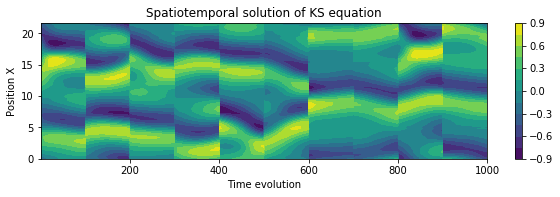

###################################
The prediction


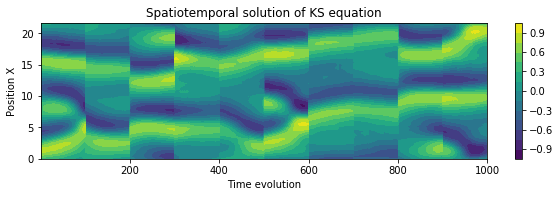

The true value


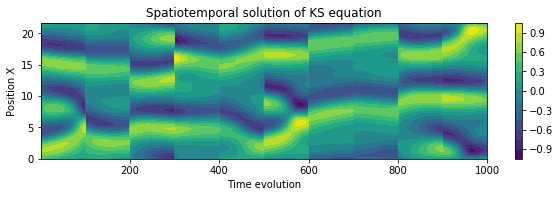

###################################
The prediction


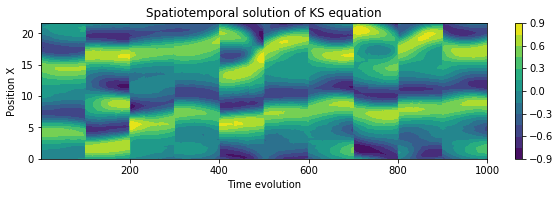

The true value


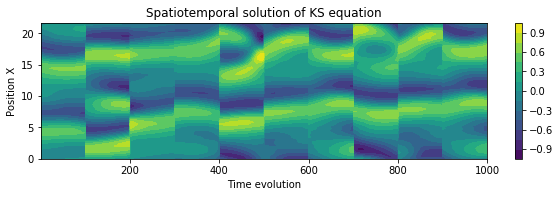

###################################


In [ ]:
#KSflow
for i in range(100):
    print('The prediction')
    drawKS(statespred1[:,:,i], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
    print('The true value')
    drawKS(statespred2[:,:,i], position_x, time_counter ,startT=1,endT=1500, width = 10, divwidth = 4)
    print("###################################")

In [ ]:
for jj in range(Number_of_Models):
    for ii in range(start_positions_1.shape[0]):
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        number_of_steps_pred=int(size_conv_time/steps_to_predict)
        for i in range(int(N_step_simu/number_of_steps_pred)):
            if i==0:
                pp1,yy1,dif1 = prediction(model,pos_1,number_of_steps_pred,steps_to_predict,size_conv_time,state_history_norm_th)
                pp2,yy2,dif2 = prediction(model,pos_2,number_of_steps_pred,steps_to_predict,size_conv_time,state_history_norm_th)
                delta_all_models_1[jj,i*steps_to_predict:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif1
                delta_all_models_2[jj,i*steps_to_predict:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif2
                statespred1[0:size_conv_time,:,ii]=pp1
                statespred2[0:size_conv_time,:,ii]=yy1

            else:
                pos_1 = size_conv_time
                pos_2 = size_conv_time
                pp1_u = min_max_scaler.inverse_transform(pp1)
                pp2_u = min_max_scaler.inverse_transform(pp2)
                state_history1, time_counter, position_x = generatingdata(pp1_u[size_conv_time-1], length,sample_points,dt,size_conv_time*dt)
                state_history2, time_counter, position_x = generatingdata(pp2_u[size_conv_time-1], length,sample_points,dt,size_conv_time*dt)            

                #normalizing the data generated:
                state_history1 = min_max_scaler.transform(state_history1)
                state_history2 = min_max_scaler.transform(state_history2)
                std_ytrue1 = np.std(state_history1,axis=0)
                std_ytrue2 = np.std(state_history2,axis=0)
                
                pp1_th = th.from_numpy(pp1).cuda()
                current_state = th.zeros((1, sample_points, size_conv_time))
                current_state[0,:,:] = pp1_th.T
                current_state=current_state.double().cuda()
                for jjj in range(number_of_steps_pred):
                    y=model(current_state)
                    yy=y[0].reshape(sample_points,steps_to_predict)
                    yy=yy.T
                    pp1_th[jjj:jjj+steps_to_predict,:]=yy
                pp1=pp1_th.cpu().detach().numpy()
                statespred1[i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,:,ii]=pp1
                
                pp2_th = th.from_numpy(pp2).cuda()
                current_state = th.zeros((1, sample_points, size_conv_time))
                current_state[0,:,:] = pp2_th.T
                current_state=current_state.double().cuda()
                for jjj in range(number_of_steps_pred):
                    y=model(current_state)
                    yy=y[0].reshape(sample_points,steps_to_predict)
                    yy=yy.T
                    pp2_th[jjj:jjj+steps_to_predict,:]=yy
                pp2=pp2_th.cpu().detach().numpy()
                statespred2[i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,:,ii]=pp2
                
                dif1=np.sqrt(np.mean(((pp1-state_history1[1:])*(pp1-state_history1[1:]))/std_ytrue1,axis=1))
                dif2=np.sqrt(np.mean(((pp2-state_history2[1:])*(pp2-state_history2[1:]))/std_ytrue2,axis=1))
                
                delta_all_models_1[jj,i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif1
                delta_all_models_2[jj,i*steps_to_predict*number_of_steps_pred:(i+1)*steps_to_predict*number_of_steps_pred,ii] = dif2
                
#taking the mean value of all positions
d1=np.mean(delta_all_models_1,axis=2)
d2=np.mean(delta_all_models_2,axis=2)

Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The 

The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shap

100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 

Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The 

The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shap

100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 

Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The 

The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shap

100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 

Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The 

The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shap

100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 

Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The 

The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shape is: (151, 64)
The final time: 7.5
Running for :  7.5 seconds with 150 iteractions
100th iteraction: ok
The state_history shap

## Comparing the prediction of the model and simulators for the data generated by the model (2)

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [ ]:
size_conv_time=150
steps_to_predict=50

# Load the the model
checkpoint = th.load("modelcv3_model2_u3")

# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

Number_of_Models = 1 

total_prediction = 500

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=100000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2 = 100
startpoint_2 = 100000
finalpoint_2 = 185000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

#to save directly the prediction and the true value
statespred1 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0],2))
statespred2 = np.zeros((total_prediction,sample_points,start_positions_1.shape[0],2)) 

In [ ]:
for jj in range(Number_of_Models):
    for ii in range(start_positions_1.shape[0]):
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        N_step_simu=int(total_prediction/steps_to_predict)
        pp1,yy1,dif1 = prediction(model,pos_1,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp2,yy2,dif2 = prediction(model,pos_2,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
        pp1_u = min_max_scaler.inverse_transform(pp1)
        pp2_u = min_max_scaler.inverse_transform(pp2)
        statespred1[:,:,ii,0]=pp1_u
        statespred2[:,:,ii,0]=pp2_u
        for i in range(total_prediction):
            state_history1, time_counter, position_x = generatingdata(pp1_u[i], length,sample_points,dt,dt)
            state_history2, time_counter, position_x = generatingdata(pp2_u[i], length,sample_points,dt,dt)
            statespred1[i,:,ii,1]=state_history1[1]
            statespred2[i,:,ii,1]=state_history2[1]
#taking the mean value of all positions
#d1=np.mean(delta_all_models_1,axis=2)
#d2=np.mean(delta_all_models_2,axis=2)

In [ ]:
#taking the mean value of all positions
dif1 = np.absolute(statespred1[1:,:,:,0]-statespred1[:-1,:,:,1])
dif2 = np.absolute(statespred2[1:,:,:,0]-statespred2[:-1,:,:,1])
d1=np.mean(dif1,axis=2)
d2=np.mean(dif2,axis=2)
d1.shape

(499, 64)

In [ ]:
M1 = np.mean(d1, axis=1)
M2 = np.mean(d2, axis=1)

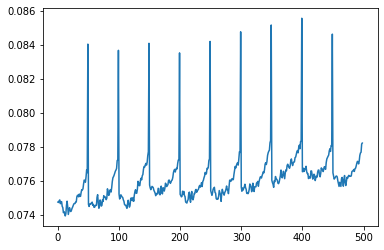

In [ ]:
plt.figure()
plt.plot(M1)
#plt.plot(M2)
plt.show()

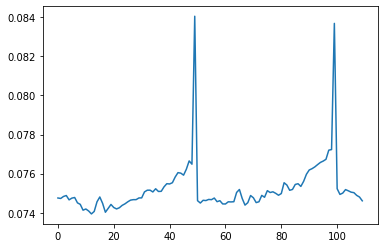

In [ ]:
plt.figure()
plt.plot(M1[0:110])
#plt.plot(M2[0:110],'*')
plt.show()

The prediction


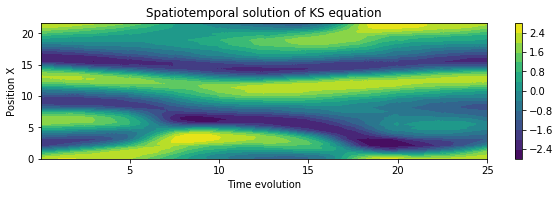

The true value


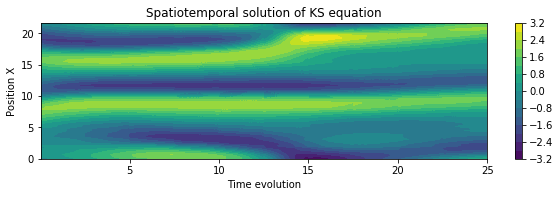

###################################


In [ ]:
time_counter = np.linspace(0,0.05*500,500)
#KSflow
print('The prediction')
drawKS(statespred1[:,:,3,0], position_x, time_counter ,startT=1,endT=500, width = 10, divwidth = 4)
print('The true value')
drawKS(statespred2[:,:,3,1], position_x, time_counter ,startT=1,endT=500, width = 10, divwidth = 4)
print("###################################")

### Comparing the models trained with different datasets

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/different_datasets/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\different_datasets


In [ ]:
size_conv_time=150
steps_to_predict=50

# names of the models
Number_of_Models = 6
names = ['modelcv3_model2_u1', 'modelcv3_model2_u2','modelcv3_model2_u3','modelcv3_model2_u4','modelcv3_model2_u1u2u3','modelcv3_model2_u1u2u3u4']

Number_of_Datasets = 4
datasetnames=['u1','u2','u3','u4']

N_step_simu = 60

total_prediction = N_step_simu*steps_to_predict

#positions to compare. in this case, it is all positions already seen by the model (training set)

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=90000
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model (test set)

numberofpos_2 = 100
startpoint_2 = 110000
finalpoint_2 = 190000 #it must be a number < steps_to_predict of all models
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)

comparator_1 = np.zeros((Number_of_Models,Number_of_Datasets, total_prediction, numberofpos_1))
comparator_2 = np.zeros((Number_of_Models,Number_of_Datasets, total_prediction, numberofpos_2))

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))

aux=0
for k in names:
    # Load the the model
    checkpoint = th.load(k)
    # restore the model states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    for i in range(Number_of_Datasets):
        print(datasetnames[i])
        state_history = np.loadtxt('state_history_'+ datasetnames[i] +'.dat')
        state_history_norm = min_max_scaler.fit_transform(state_history)
        state_history_norm_th = th.from_numpy(state_history_norm).cuda()
        del state_history
        del state_history_norm
        #making the prediction
        for ii in range(numberofpos_1):
            #making the prediction
            pp1,yy1,dif1 = prediction(model,int(start_positions_1[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
            pp2,yy2,dif2 = prediction(model,int(start_positions_2[ii]),N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)
            comparator_1[aux,i,:,ii] = dif1
            comparator_2[aux,i,:,ii] = dif2
        del state_history_norm_th
    aux=aux+1
#taking the mean of all positions
c1=np.mean(comparator_1,axis=3)
c2=np.mean(comparator_2,axis=3)

C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Callado\Anaconda3\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Tanh' has changed. you can retrieve the original source code by accessing the object's source attrib

u1
u2
u3
u4


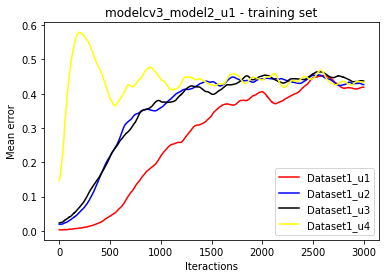

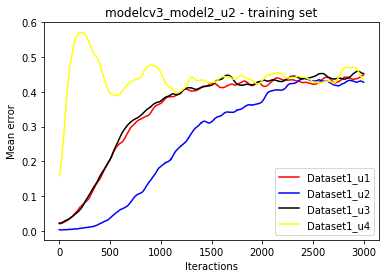

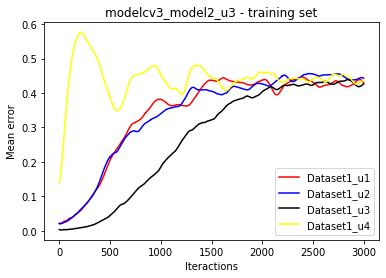

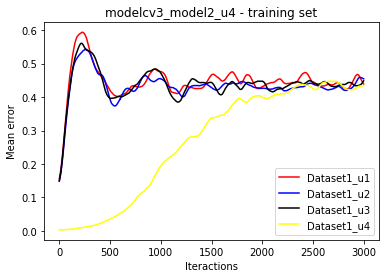

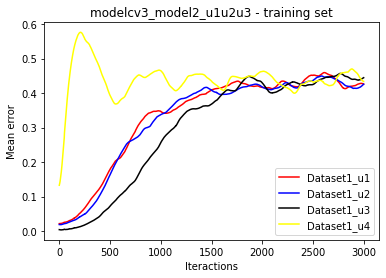

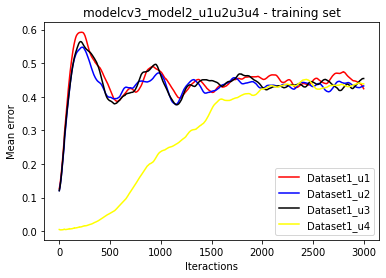

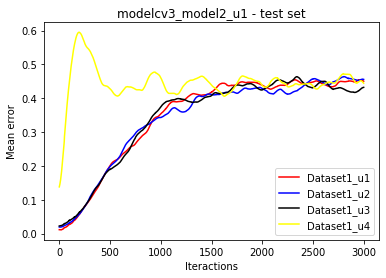

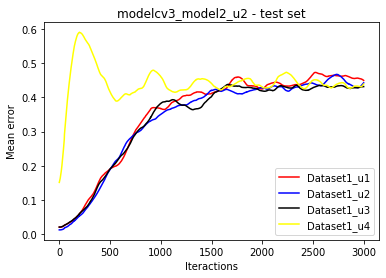

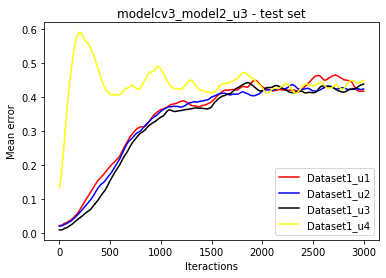

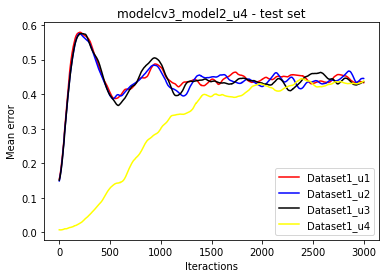

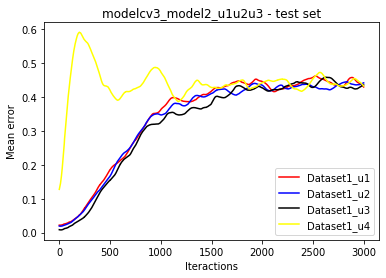

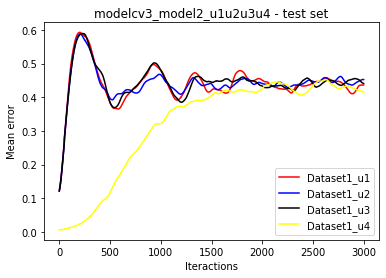

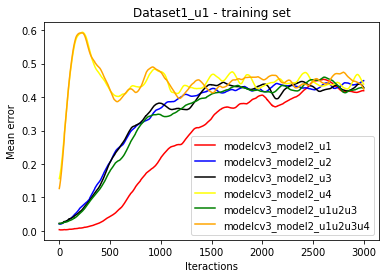

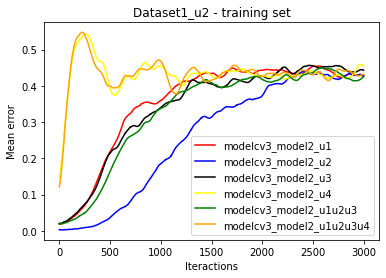

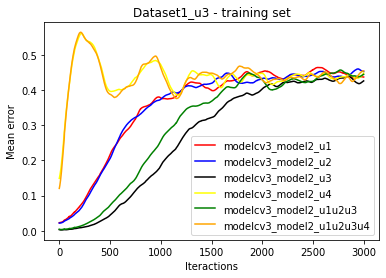

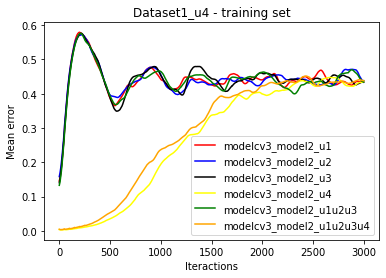

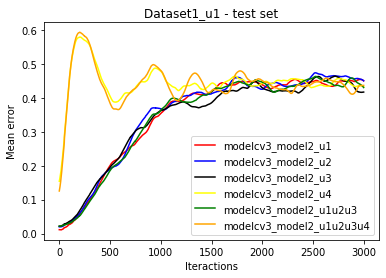

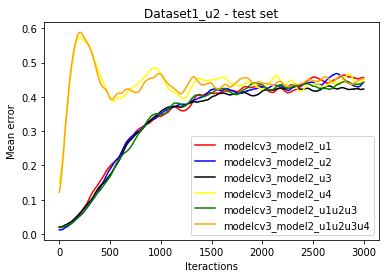

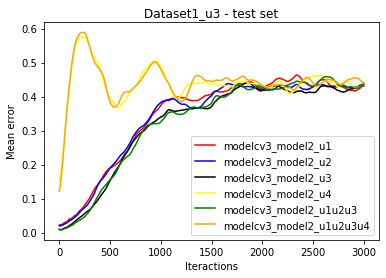

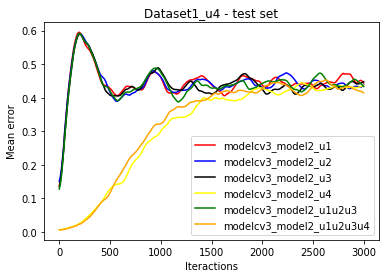

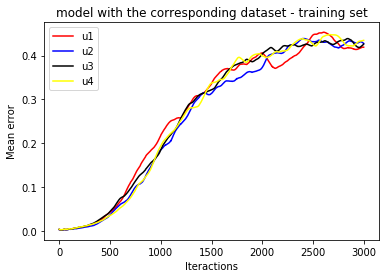

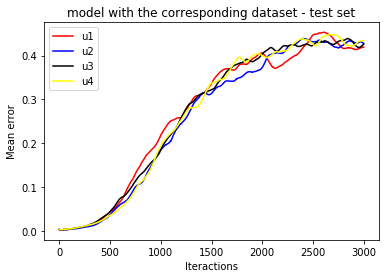

In [ ]:
#DATASET1

colors = ['red','blue','black','yellow']
legends = ['Dataset1_u1','Dataset1_u2','Dataset1_u3','Dataset1_u4']

aux=0
for j in names:
    plt.figure()
    for i in range(Number_of_Datasets):
        plt.plot(c1[aux,i,:],colors[i])
    plt.legend(legends)
    plt.ylabel('NRMSE')
    plt.xlabel('Iteractions')
    plt.title(j+' - training set')
    plt.show()
    aux=aux+1

legends = ['Dataset1_u1','Dataset1_u2','Dataset1_u3','Dataset1_u4']

aux=0
for j in names:
    plt.figure()
    for i in range(Number_of_Datasets):
        plt.plot(c2[aux,i,:],colors[i])
    plt.legend(legends)
    plt.ylabel('NRMSE')
    plt.xlabel('Iteractions')
    plt.title(j+' - test set')
    plt.show()
    aux=aux+1

colors2 = ['red','blue','black','yellow', 'green','orange']

for i in range(Number_of_Datasets):
    plt.figure()
    aux=0
    for j in names:
        plt.plot(c1[aux,i,:],colors2[aux])
        aux=aux+1
    plt.legend(names)
    plt.ylabel('NRMSE')
    plt.xlabel('Iteractions')
    plt.title(legends[i]+' - training set')
    plt.show()
    
for i in range(Number_of_Datasets):
    plt.figure()
    aux=0
    for j in names:
        plt.plot(c2[aux,i,:],colors2[aux])
        aux=aux+1
    plt.legend(names)
    plt.ylabel('NRMSE')
    plt.xlabel('Iteractions')
    plt.title(legends[i]+' - test set')
    plt.show()

plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,i,:],colors[i])
plt.legend(datasetnames)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('model with the corresponding dataset - training set')
plt.show()
    
plt.figure()
for i in range(Number_of_Datasets):
    plt.plot(c1[i,i,:],colors[i])
plt.legend(datasetnames)
plt.ylabel('NRMSE')
plt.xlabel('Iteractions')
plt.title('model with the corresponding dataset - test set')
plt.show()

## Calculating the PSD

In [ ]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [ ]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [ ]:
# Load the the model
checkpoint = th.load('modelcv3_model2_u3')
# restore the model states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()

In [ ]:
state_history_norm_th.shape

torch.Size([200001, 64])

Making the prediction:

In [ ]:
size_conv_time=150
steps_to_predict=50
N_step_simu=200
total_time_pred = N_step_simu*steps_to_predict
start_pos =  12000


pred,true,dif = prediction(model,start_pos,N_step_simu,steps_to_predict,size_conv_time,state_history_norm_th)

(array([[1.46390896e-02, 4.29868163e-01, 1.38028582e+00, ...,
         1.30863552e-04, 7.27929388e-06, 2.01402971e-05],
        [1.44165148e-02, 4.28251915e-01, 1.37543261e+00, ...,
         1.31020918e-04, 7.31918724e-06, 2.01227526e-05],
        [1.41975240e-02, 4.26665756e-01, 1.37059035e+00, ...,
         1.31175721e-04, 7.35892877e-06, 2.01049921e-05],
        ...,
        [5.73011575e-03, 1.15069300e-01, 1.04270973e+00, ...,
         8.80459973e-05, 5.35161983e-06, 3.03435570e-05],
        [5.95074491e-03, 1.14837147e-01, 1.04452572e+00, ...,
         8.80197640e-05, 5.36187864e-06, 3.02927687e-05],
        [6.17621468e-03, 1.14616290e-01, 1.04644674e+00, ...,
         8.79954679e-05, 5.37266929e-06, 3.02432731e-05]]),
 array([[1.38735153e-02, 4.27908074e-01, 1.36143111e+00, ...,
         1.93984927e-04, 4.64873665e-05, 5.09071160e-07],
        [1.34799761e-02, 4.24644548e-01, 1.35469606e+00, ...,
         2.30779834e-04, 6.68269493e-05, 1.14013915e-07],
        [1.31364466e-02, 

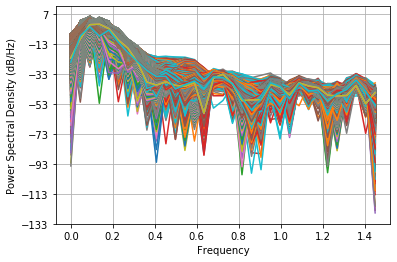

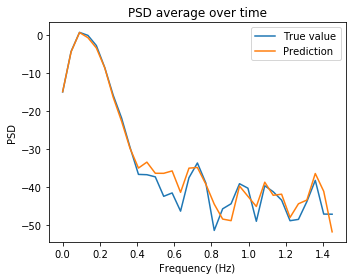

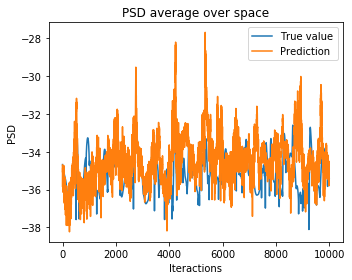

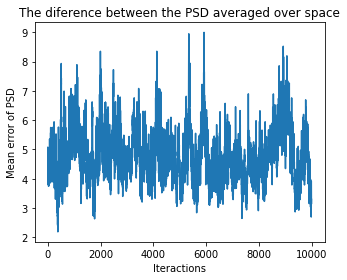

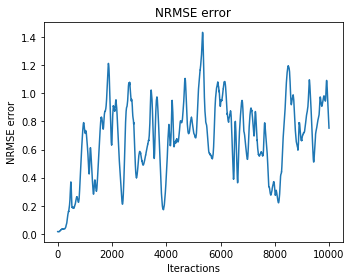

In [ ]:
psd_true, psd_pred = PSD(pred,true,dif,total_time_pred)

## Calculating the VPT

###changing steps_to_predict

In [ ]:
epsolon = 0.07
Number_of_Models = 10
sp = [2,4,6,8,10,12,14,16,18,20] #steps_to_predict of the models
st = [25,25,25,25,25,25,25,25,25,25] #size_conv_time of the models

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=400 #it must be a number > size_conv_time of all models
finalpoint_1=394400
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2=100
startpoint_2=400050 #it must be a number > size_conv_time of all models
finalpoint_2=793000
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


vpt_1 = np.zeros((Number_of_Models,start_positions_1.shape[0]))
vpt_2 = np.zeros((Number_of_Models,start_positions_2.shape[0]))

In [ ]:
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model="modelcv_model2_2_500epochs_stepspred"
    nmodel=str(i)
    name = type_of_model + nmodel
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        vpt_1[i,ii] = VPT(model, pos_1, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        vpt_2[i,ii] = VPT(model, pos_2, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        
#taking the mean value of all positions
d1=np.mean(vpt_1,axis=1)
d2=np.mean(vpt_2,axis=1)

[0.5631301  0.73415747 0.78708593 0.80472876 0.89846375 0.97131541
 1.05856937 1.06144983 1.05604897 1.04368699]
[0.518723   0.65158425 0.73175708 0.84481517 0.88202112 0.92630821
 1.06096976 0.97839654 1.02568411 1.05400864]


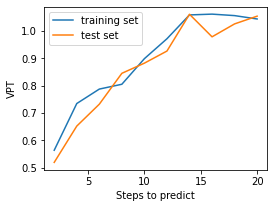

In [ ]:
print(d1)
print(d2)

plt.figure(figsize=(4,3))
plt.plot(sp, d1)
plt.plot(sp, d2)
plt.xlabel('Steps to predict')
plt.ylabel('VPT')
labels = ['training set', 'test set']
plt.legend(labels)


###changing size_conv_time

In [ ]:
epsolon = 0.07
Number_of_Models = 1
sp = [10,10,10,10,10,10,10,10,10,10] #steps_to_predict of the models
st = [2,4,6,8,10,12,14,16,18,20] #size_conv_time of the models

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=300
startpoint_1=400 #it must be a number > size_conv_time of all models
finalpoint_1=394400
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2=300
startpoint_2=400050 #it must be a number > size_conv_time of all models
finalpoint_2=793000
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


vpt_1 = np.zeros((Number_of_Models,start_positions_1.shape[0]))
vpt_2 = np.zeros((Number_of_Models,start_positions_2.shape[0]))

In [ ]:
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model=["modelcv_model2_2_500epochs_sizeconv0"]
    #nmodel=str(i)
    name = type_of_model[i]
    checkpoint = th.load(name)
    # restore the model:
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        vpt_1[i,ii] = VPT(model, pos_1, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        vpt_2[i,ii] = VPT(model, pos_2, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        
#taking the mean value of all positions
d1=np.mean(vpt_1,axis=1)
d2=np.mean(vpt_2,axis=1)

In [ ]:
print(d1)
print(d2)

[1.01496239]
[0.98307729]


In [ ]:
print(d1)
print(d2)

[0.94679149]
[0.93006881]


[0.94679149 0.98491759 0.81200992 0.94495119 0.99607937 0.91610658
 0.97071531 1.07413186 1.05656905 1.04052648]
[0.93006881 0.98979837 0.83097296 0.93458953 0.99003841 0.92986878
 0.94635142 1.02168347 1.01568251 1.02344375]


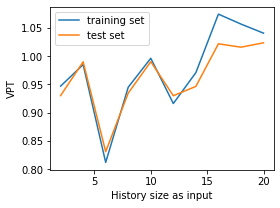

In [ ]:
print(d1)
print(d2)

plt.figure(figsize=(4,3))
plt.plot(st, d1)
plt.plot(st, d2)
plt.xlabel('History size as input')
plt.ylabel('VPT')
labels = ['training set', 'test set']
plt.legend(labels)

### changing hyperparameters

In [ ]:
epsolon = 0.07
Number_of_Models = 3
sp = [10,10,10] #steps_to_predict of the models
st = [25,25,25] #size_conv_time of the models

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=200
startpoint_1=400 #it must be a number > size_conv_time of all models
finalpoint_1=394400
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2=200
startpoint_2=400050 #it must be a number > size_conv_time of all models
finalpoint_2=793000
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


vpt_1 = np.zeros((Number_of_Models,start_positions_1.shape[0]))
vpt_2 = np.zeros((Number_of_Models,start_positions_2.shape[0]))

In [ ]:
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model=["modelcv_model1_1_500epochs","modelcv_model2_1_500epochs","modelcv_model3_1_500epochs"]
    name = type_of_model[i]
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        vpt_1[i,ii] = VPT(model, pos_1, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        vpt_2[i,ii] = VPT(model, pos_2, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        
#taking the mean value of all positions
d1=np.mean(vpt_1,axis=1)
d2=np.mean(vpt_2,axis=1)

[0.48115699 0.75168027 1.05082813]
[0.46639462 0.77352376 0.96519443]


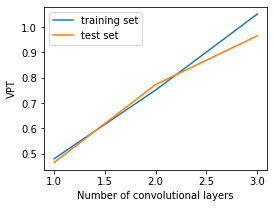

In [ ]:
print(d1)
print(d2)

plt.figure(figsize=(4,3))
plt.plot([1,2,3], d1)
plt.plot([1,2,3], d2)
plt.xlabel('Number of convolutional layers')
plt.ylabel('VPT')
labels = ['training set', 'test set']
plt.legend(labels)

In [ ]:
## FF models

epsolon = 0.07
Number_of_Models = 4

sp = [1,1,1,1] #steps_to_predict of the models
st = [1,1,1,1] #size_conv_time of the models

#positions to compare. in this case, it is all positions already seen by the model

numberofpos_1=100
startpoint_1=200 #it must be a number > size_conv_time of all models
finalpoint_1=399400
start_positions_1 = np.linspace(startpoint_1,finalpoint_1,numberofpos_1)

#positions to compare. in this case, it is all positions not seen by the model

numberofpos_2=100
startpoint_2=400050 #it must be a number > size_conv_time of all models
finalpoint_2=799400
start_positions_2 = np.linspace(startpoint_2,finalpoint_2,numberofpos_2)


vpt_1 = np.zeros((Number_of_Models,start_positions_1.shape[0]))
vpt_2 = np.zeros((Number_of_Models,start_positions_2.shape[0]))

In [ ]:
for i in range(Number_of_Models):
    
    #TO LOAD THE MODEL. pay attention with the name!!!
    
    type_of_model="modelff"
    nmodel=str(i+1)
    name = type_of_model + nmodel
    
    checkpoint = th.load(name)
    # restore the model and optimizer states: 
    model = checkpoint['model']
    model.load_state_dict(checkpoint['model_state_dict'])
    #steps_to_predict=checkpoint['steps_to_predict']
    #size_conv_time=checkpoint['size_conv_time']
    
    for ii in range(start_positions_1.shape[0]):
        steps_to_predict = sp[i]
        size_conv_time = st[i]
        pos_1=int(start_positions_1[ii])
        pos_2=int(start_positions_2[ii])
        vpt_1[i,ii] = VPTFF(model, pos_1, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        vpt_2[i,ii] = VPTFF(model, pos_2, epsolon, steps_to_predict, size_conv_time, state_history_norm_th)
        
#taking the mean value of all positions
d1=np.mean(vpt_1,axis=1)
d2=np.mean(vpt_2,axis=1)

In [ ]:
print(d1)
print(d2)

[0.27712434 0.28600576 0.38406145 0.53540566]
[0.27184349 0.25852136 0.4150264  0.54620739]
